# Upgrade OCR
## Introduction
The goal of this file is to find preprocessing ways in order to upgrade OCR's efficiency

## Import

In [86]:
import sys
sys.path.append('..')

import os
from time import time
import pathlib
import matplotlib.pyplot as plt
import cv2
from models_pipeline import easyOCR
from utils_.functions import plot_confusion_matrix, rotate_image
from cv2 import dnn_Model
from txt_super_res.src.model import SRResNetModel
from txt_super_res.src.dataset import ImageDataset
from blurred_img_clf.src.models import BICModel
from blurred_img_clf.src.dataset import ImageFolderDataset

In [87]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im
from scipy.ndimage import interpolation as inter

## Constant

In [88]:
IMAGES_PATH = '../utils_/data-examples/ocr/'
OUTPUT_PATH = './outputs/'
JSON_TEST_PATH = '../utils_/data-examples/ocr/references.json'

## Code

In [89]:
def plot_images(im_before, im_after):
    fig, axes = plt.subplots(nrows=1, ncols=2, dpi=600)
    fig.tight_layout()
    
    axes[0].imshow(im_before, cmap="gray")
    axes[0].set_title("Before")
    axes[0].axis("off")
    
    axes[1].imshow(im_after, cmap="gray")
    axes[1].set_title("After")
    axes[1].axis("off")
    
    plt.show()

In [90]:
def plot_images_couples(x, y_pred):
    if len(x) != len(y_pred):
        raise Exception('Not the same length between images_be and images_af')
    fig, axes = plt.subplots(nrows=len(x), ncols=2)
    fig.tight_layout
    
    axes[0][0].set_title('x')
    axes[0][1].set_title('y_pred')
    
    for row,ax in enumerate(axes):
        ax[0].imshow(x[row], cmap="gray")
        ax[0].axis("off")
        
        ax[1].imshow(y_pred[row], cmap="gray")
        ax[1].axis("off")
    plt.show()


In [91]:
pathlib.Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

In [92]:
folder = os.listdir(IMAGES_PATH)
images = []
for file in folder:
    if file.endswith(".jpg"):
        images.append(file)
        
print(images)

['0.jpg', '1.jpg', '1327.jpg', '54074.jpg']


In [93]:
ocr = easyOCR()
config = {
    "low_text":0.5,
    "threshold":0.5,
    "min_size":5,
    "mag_ratio":3,
    "paragraph":True,
    "detail":1,
    "bbox_min_size":1,
    "contrast_ths":0.3,
    "adjust_contrast":0.5,
    "rotation_info":[180]
}

In [94]:
bleu, process_time, n_sentences = ocr.test(JSON_TEST_PATH, IMAGES_PATH, True, config)

/home/cdlab2022/anaconda3/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


0 : 0.30274468969101015
sender account 348274 markus reeken am lindgen 5a de 41542 dormagen
sende eecount 848274 markug reeken am lindgen sa de 41542 dotinagen
--------------------
1 : 0.2442224435871772
sender account 362833 danyn de jong lindenlaan 26 nl 1185na amstelveen
eonod docoun 342088 danyn de jong lindentaan 26 al 3 i18sna amstelveen
--------------------


/home/cdlab2022/anaconda3/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


2 : 1.343250984650735e-62
ship to wind sportartikel vetriebs gmbh froschengasse 4 66111 saarbrucken germany
ship 0 wind sportartikel veatriebs gmbh froschengasse 6 86111 saarbrucken geamany
--------------------
3 : 0.5667531443912753
delivery address wind sportartikel vetriebs gmbh froschengasse 4 66111 saarbrucken germany
deliery elqjppe wind sportartikel vertriebs gmbh froschengasse 4 66111 saarbrucken germany tel 
--------------------
0.2784300694173657


## Preprocessing

In [95]:
image = cv2.imread(os.path.join(IMAGES_PATH+images[0]), cv2.IMREAD_GRAYSCALE)

txt_fo = ocr.predict(image=image, **config)
print(txt_fo)

Sende eecount 848274 Markug Reeken Am lindgen Sa dE 41542 Dotinagen


https://towardsdatascience.com/pre-processing-in-ocr-fc231c6035a7

#### *Adaptative Binarization*

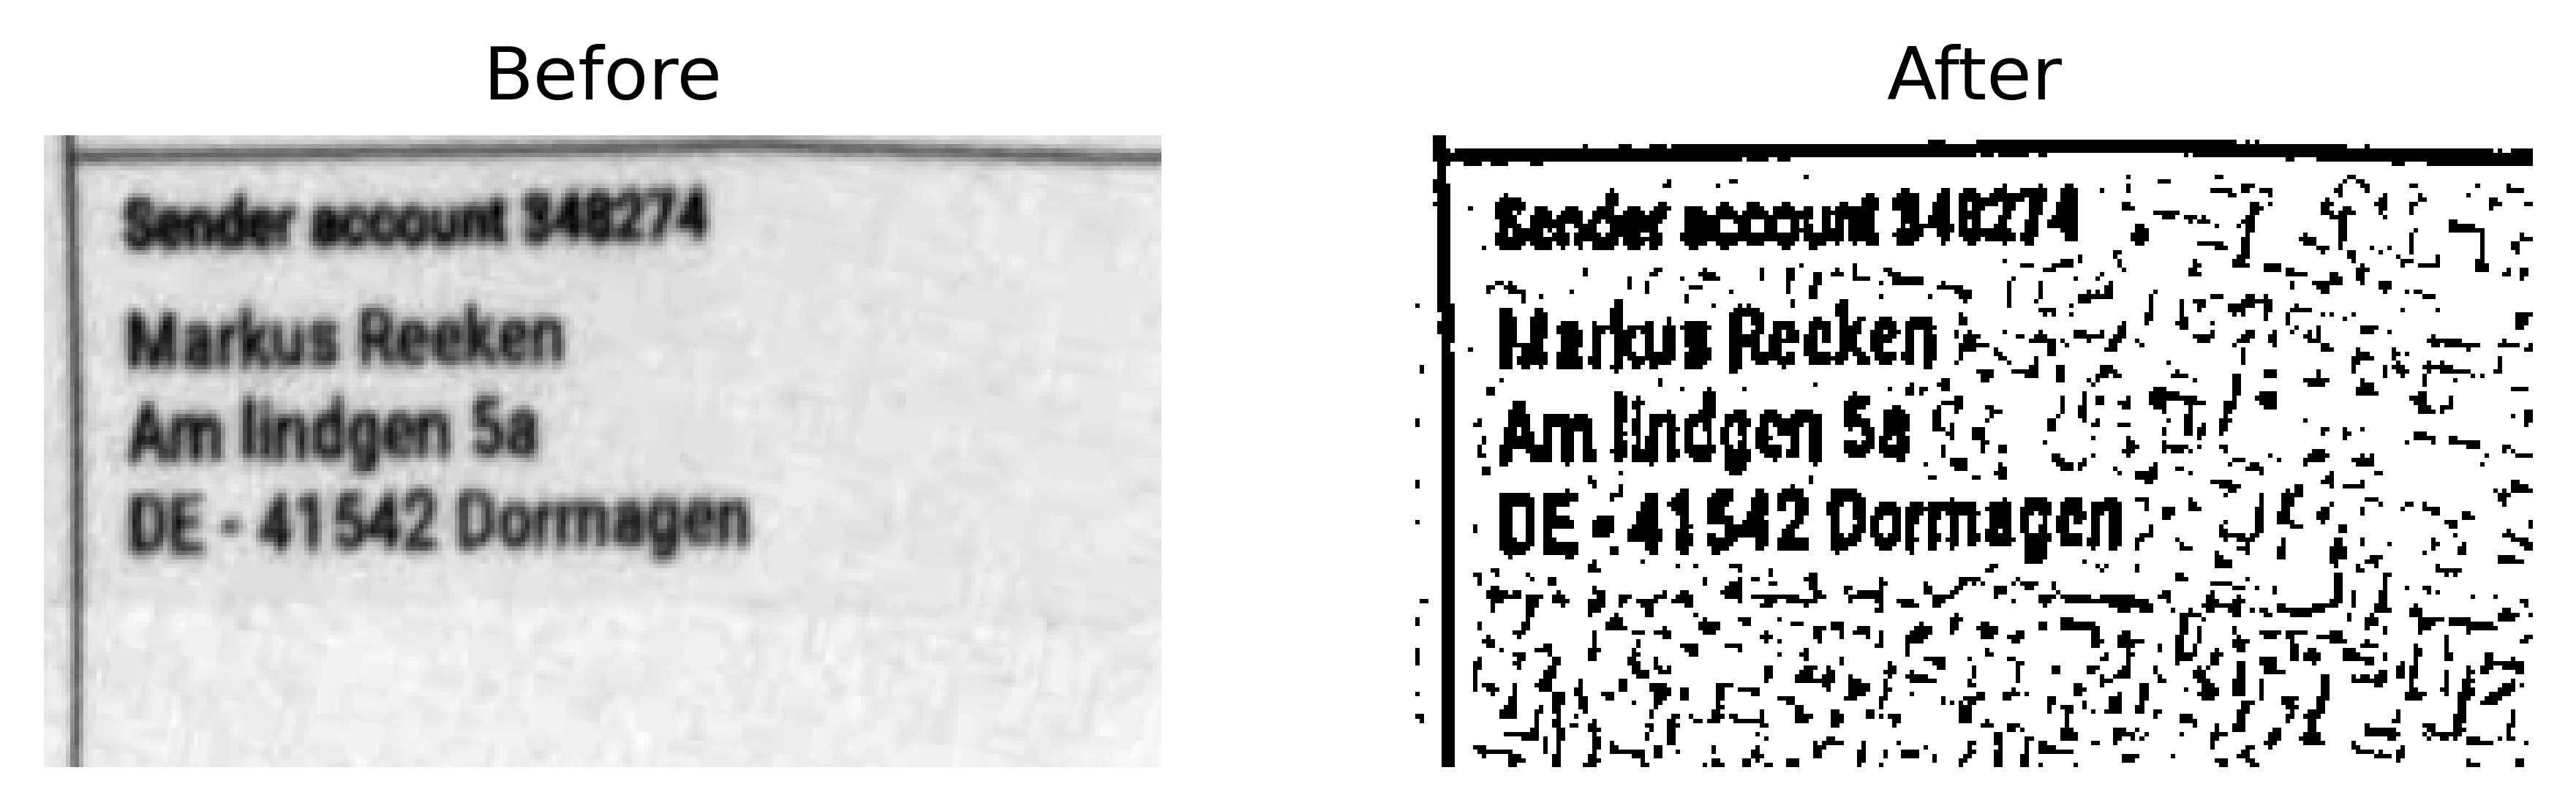

In [96]:
imgf = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2) #imgf contains Binary image

plot_images(image, imgf)

#### *Rotation*

/tmp/ipykernel_58736/1882280527.py:4: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)
/tmp/ipykernel_58736/1882280527.py:20: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(img, best_angle, reshape=True, order=0)


Best angle: -9


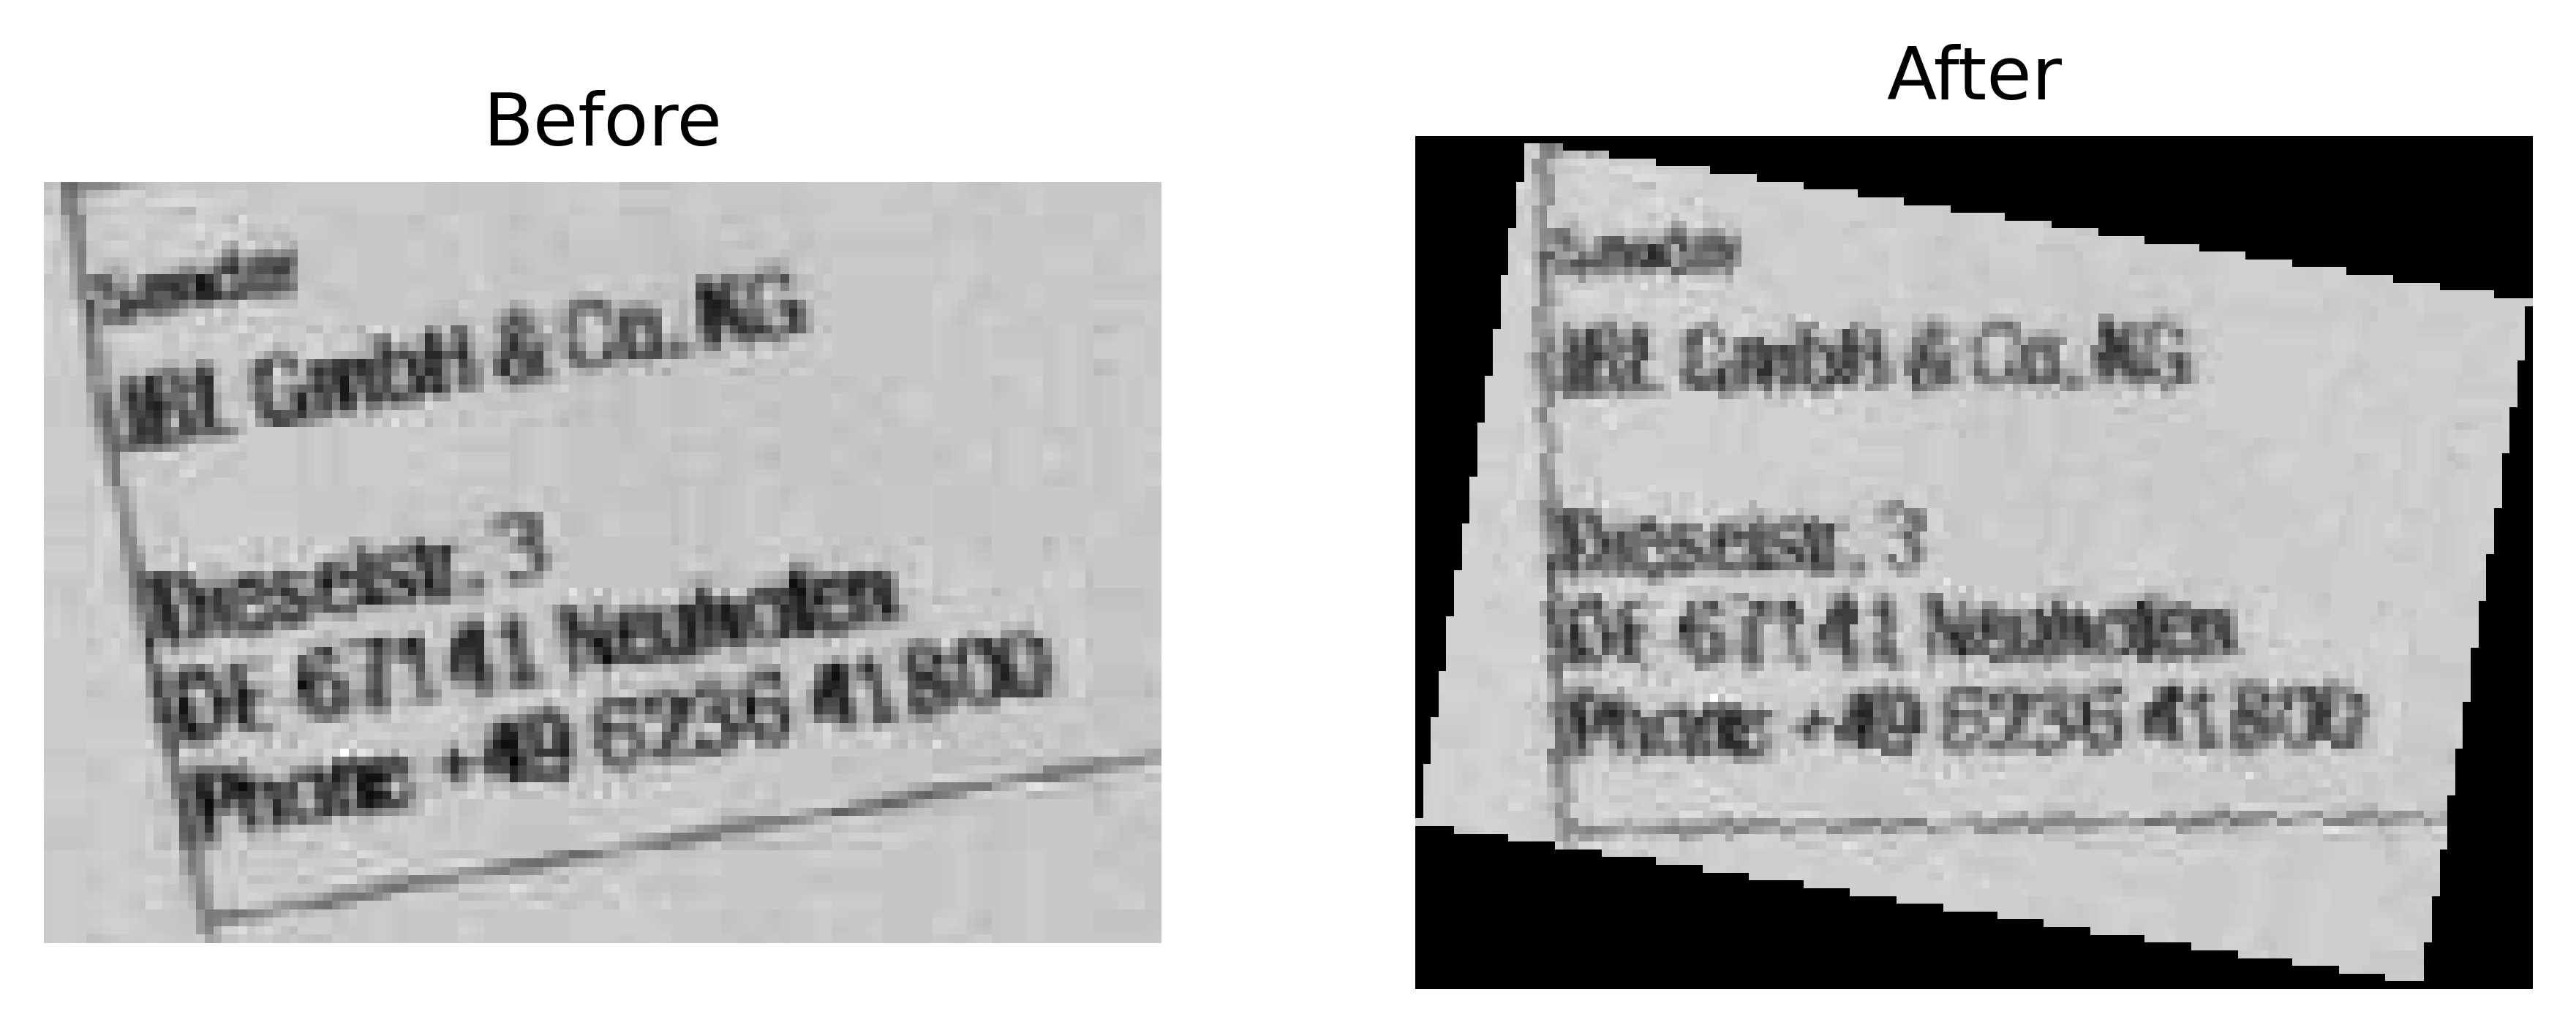

In [97]:
img = cv2.imread(os.path.join(IMAGES_PATH, '3.png'), cv2.IMREAD_GRAYSCALE)

def find_score(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score
delta = 7
limit = 100
angles = np.arange(-limit, limit+delta, delta)
scores = []

for angle in angles:
    hist, score = find_score(img, angle)
    scores.append(score)
    
best_score = max(scores)
best_angle = angles[scores.index(best_score)]
print('Best angle: {}'.format(best_angle))# correct skew
data = inter.rotate(img, best_angle, reshape=True, order=0)

plot_images(img, data)

#### *Denoizer*

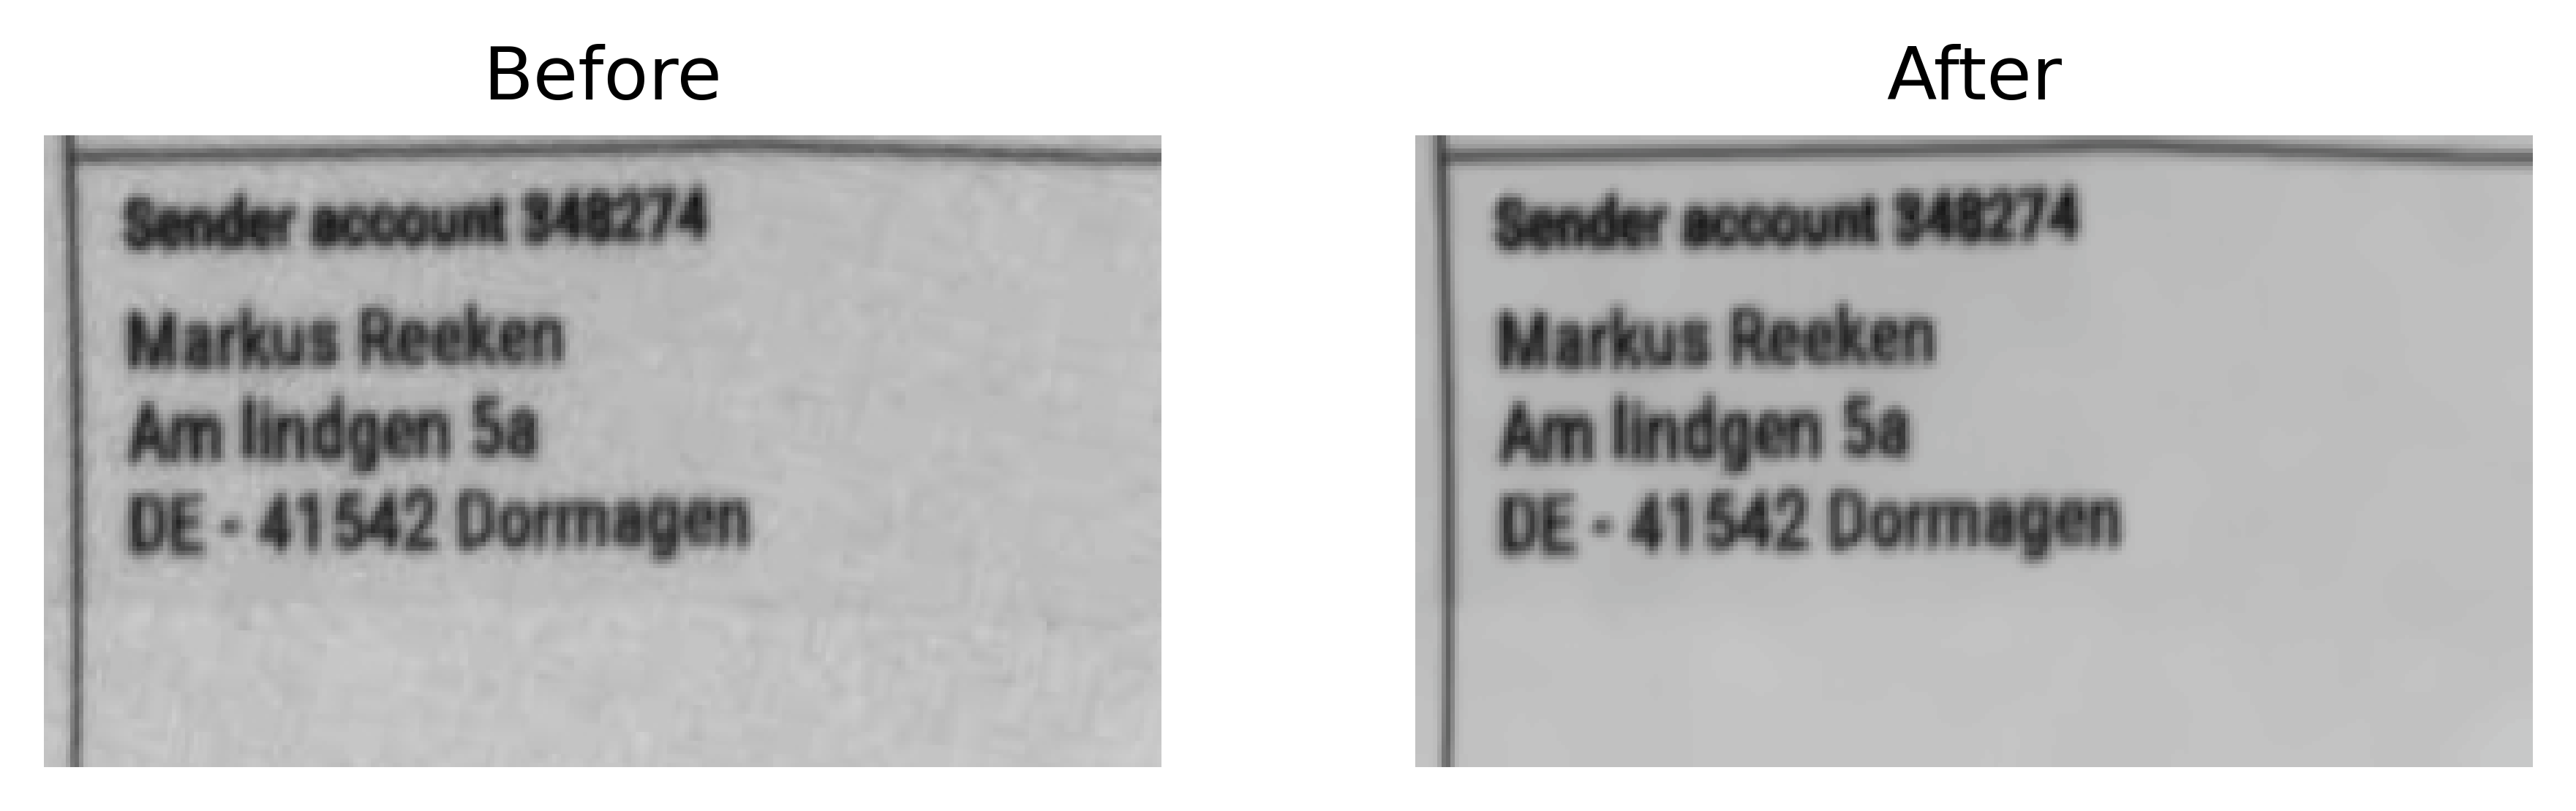

Sende eecount 848274 Markug Reeken Am lindgen Sa dE 41542 Dotinagen
Bender eccouni 948274 Markug Reeken Am lindgen S0 dE 41542 Dotiagen


In [98]:
# Reading image from folder where it is stored 
img = cv2.imread(os.path.join(IMAGES_PATH+images[0]), cv2.IMREAD_COLOR)
# denoising of image saving it into dst image 
dst = cv2.fastNlMeansDenoisingColored(img, None, 5, 10, 4, 15) 
# Plotting of source and destination image 

plot_images(img,dst)
print(txt_fo)
print(ocr.predict(image=dst, **config))

#### *Denoizer + Adaptative Threshold*

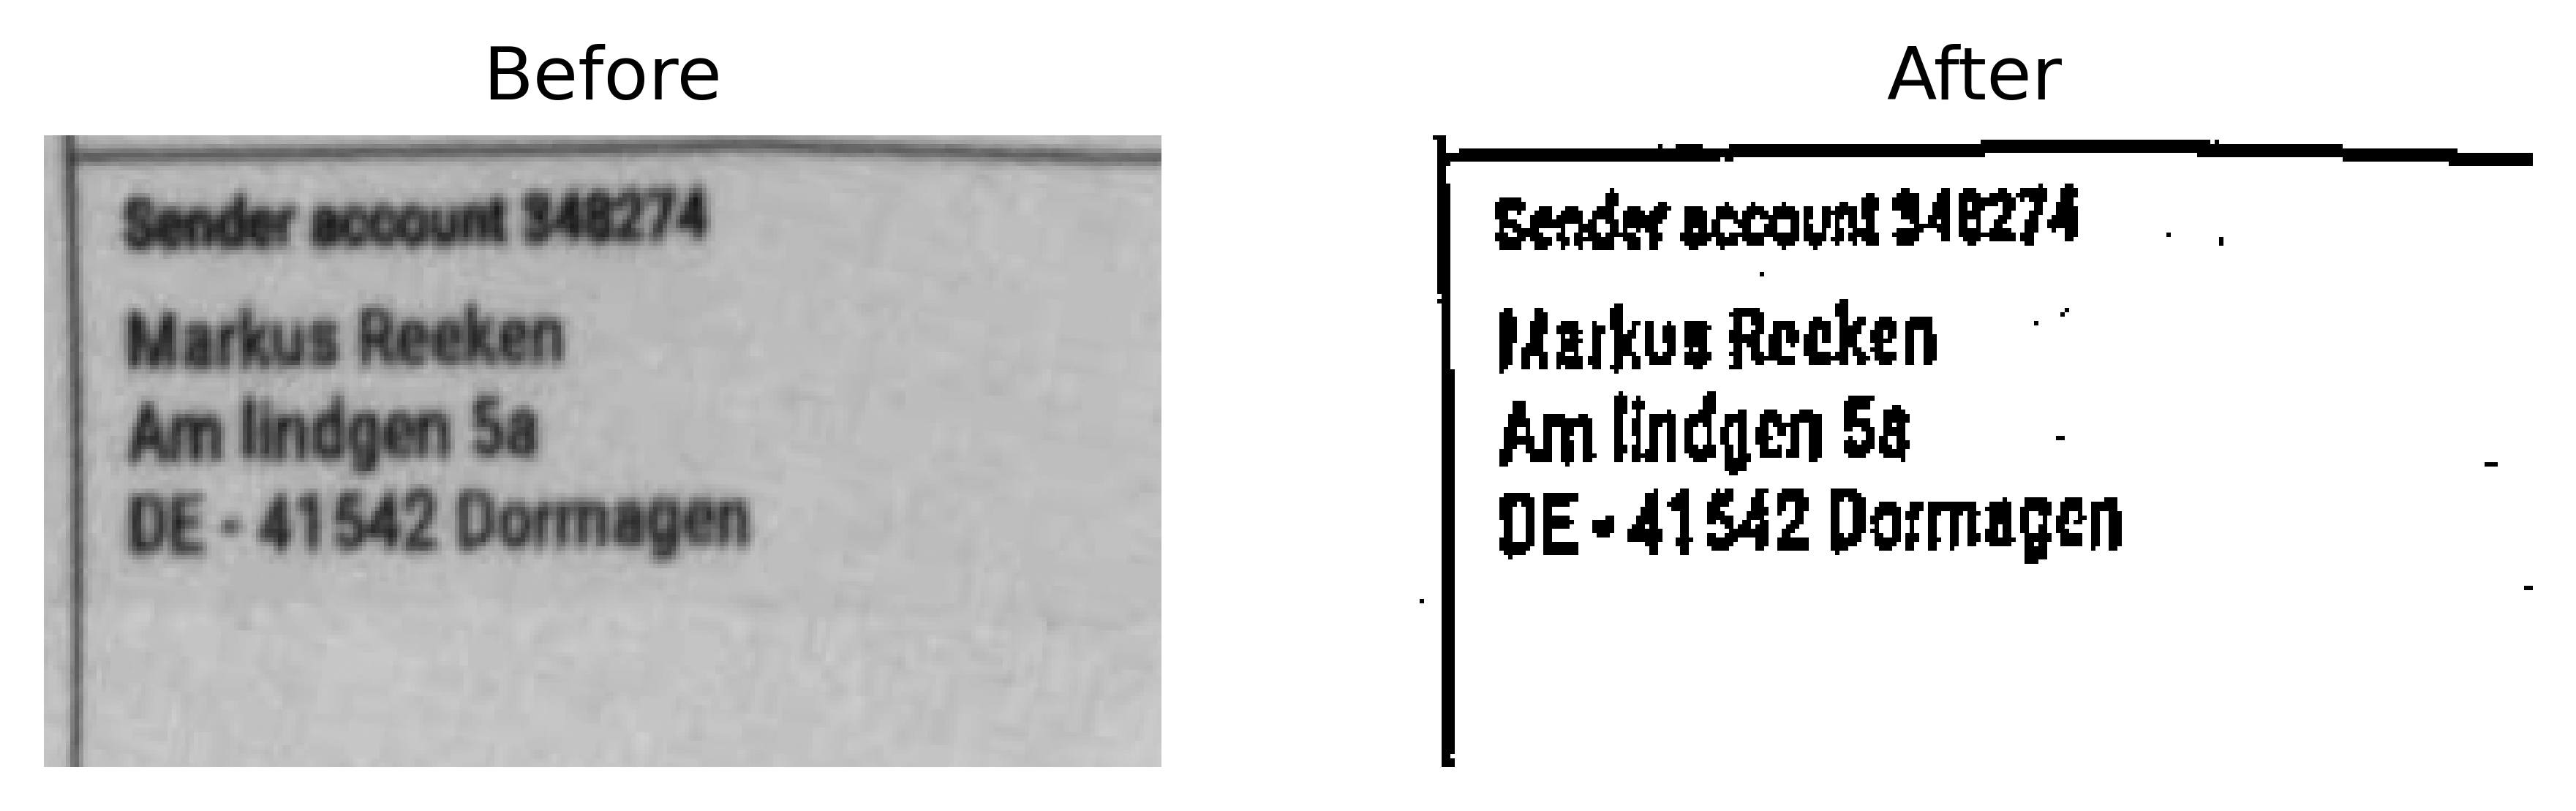

Sende eecount 848274 Markug Reeken Am lindgen Sa dE 41542 Dotinagen
tleaht: Mn370 #prts Iarkus Rccken WN lindgcn 5a QE- 41542 Doimaccn


In [99]:
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
imgf = cv2.adaptiveThreshold(dst,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7,2) #imgf contains Binary image

plot_images(img, imgf)
print(txt_fo)
print(ocr.predict(image=imgf, **config))

#### *Erosion*

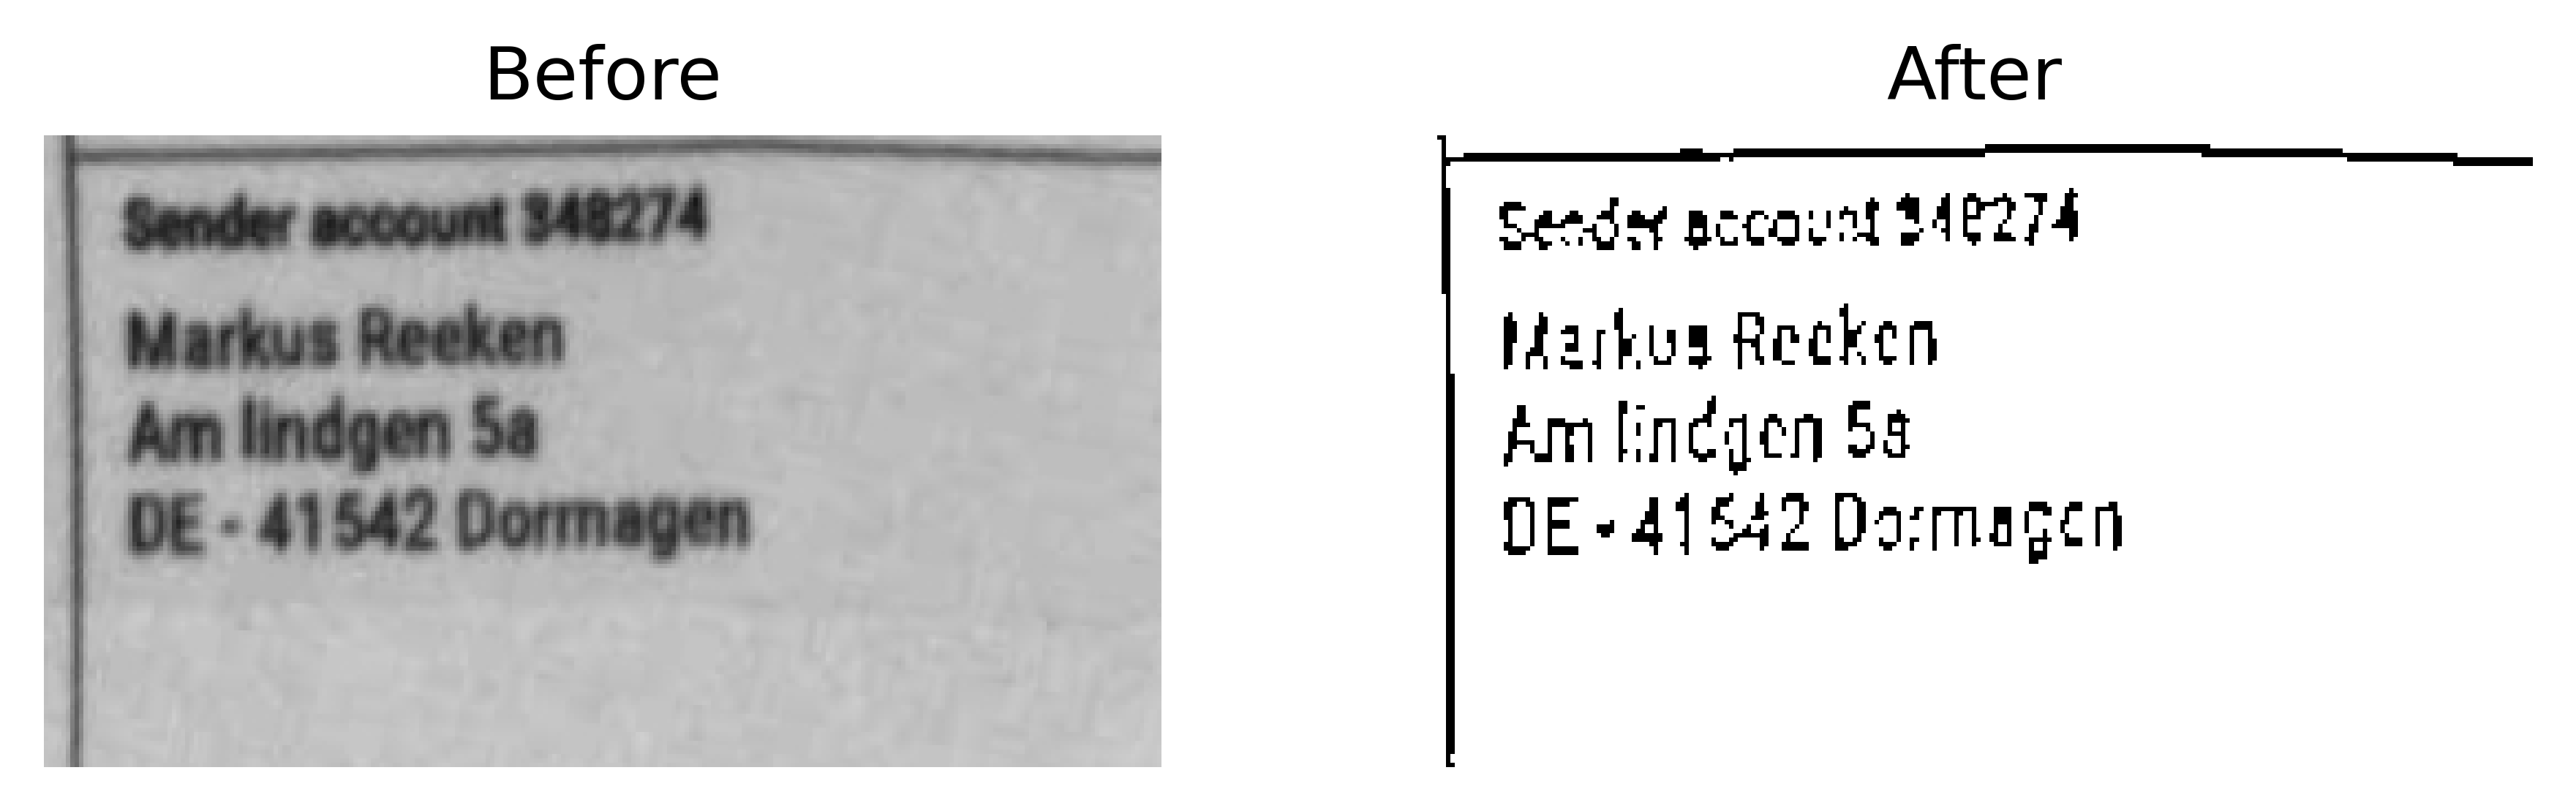

tIzabi MRojjorxnS Markuy Rcckcn WY ncacn 5a OE-41542 Domagcn


In [100]:
kernel = np.ones((2,2),np.uint8)
gray_negative = abs(255-imgf)
erosion = cv2.erode(gray_negative,kernel,iterations = 1)

plot_images(img, abs(255-erosion))
print(ocr.predict(image=abs(255-erosion), **config))

## OCR Detection

In [101]:
def draw_bboxes(bboxes, img: np.ndarray):
    img_returned = img.copy()
    for bbox in bboxes:
        a,b,c,d = bbox
        cv2.rectangle(img_returned, (a, d), (b, c), (0, 255, 0))
    return img_returned

In [139]:
def extract_bboxes(bboxes, img: np.ndarray, m=0):
    img_returned = []
    for bbox in bboxes:
        bbox = bbox
        a,b,c,d = bbox
        print(bbox)
        img_returned.append(img[c-m:d+m,a-m:b+m])
    return img_returned
    

In [103]:
ocr = easyOCR()

res = ocr.model.detect(
    img=img,
    min_size=7,
    low_text=0.5
    )   

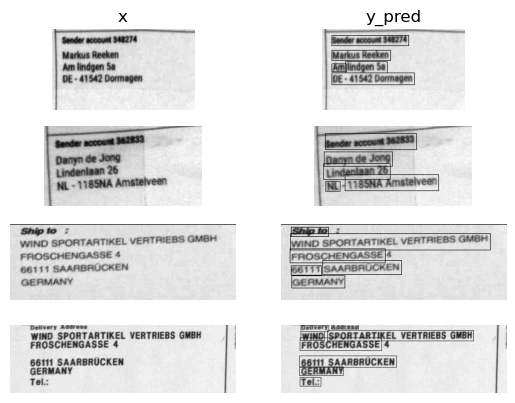

In [104]:
img_lst = []
new_img_lst = []
for image_fn in images:
    im = cv2.imread(os.path.join(IMAGES_PATH, image_fn), cv2.IMREAD_GRAYSCALE)
    img_lst.append(im)
    
    res = ocr.model.detect(
        img=im,
        min_size=7,
        low_text=0.5
    )   
    new_img_lst.append(draw_bboxes(res[0][0], im))

plot_images_couples(img_lst, new_img_lst)

[17, 81, 5, 21]
[16, 358, 16, 44]


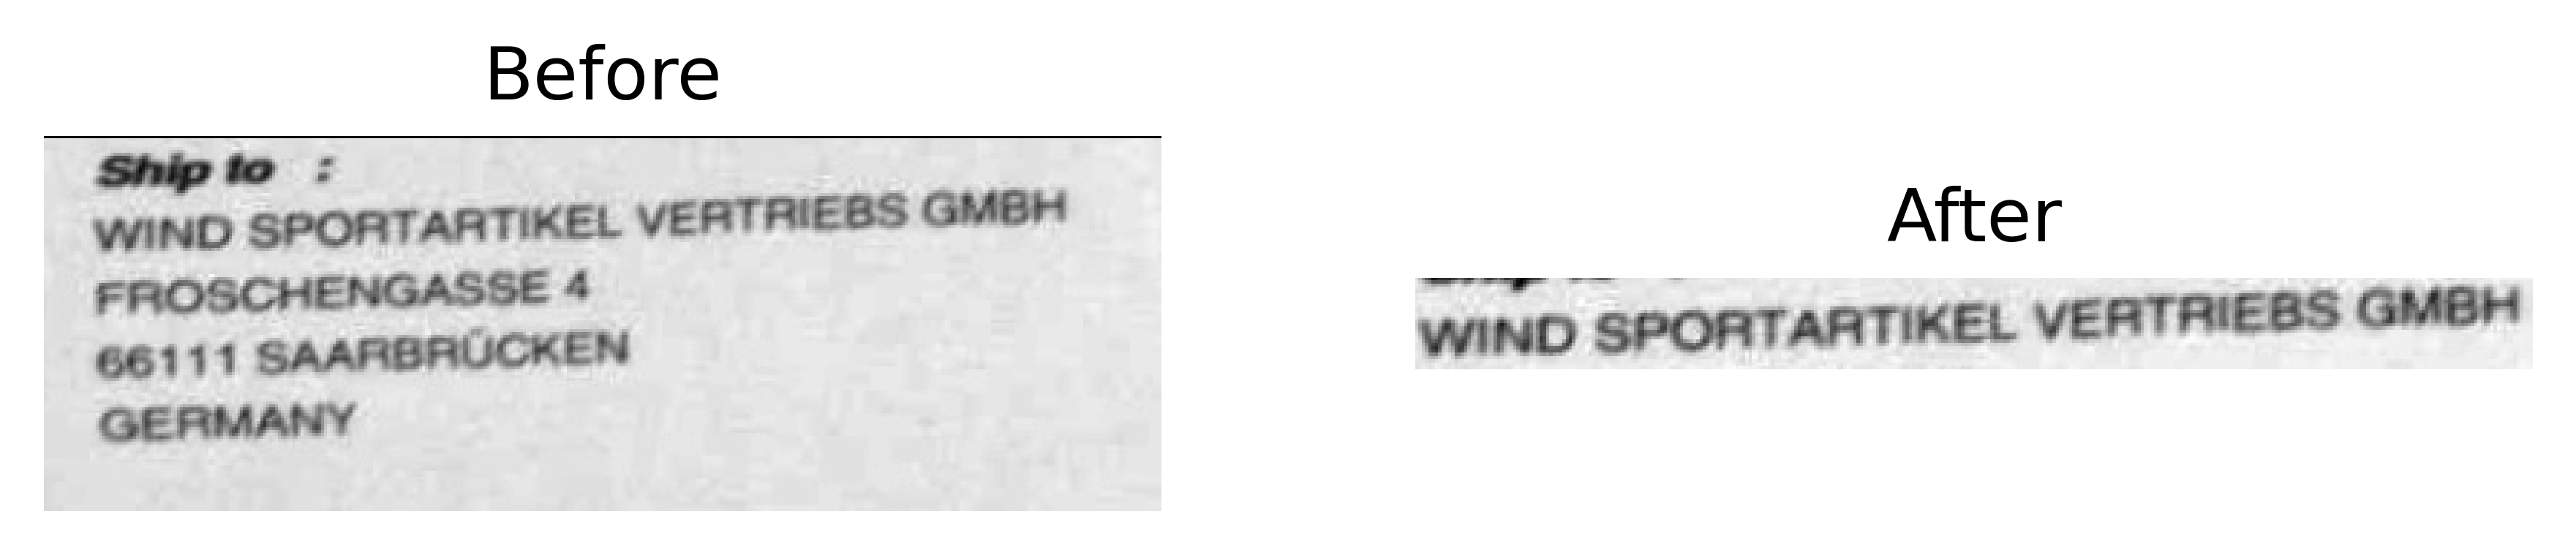

In [105]:
im = cv2.imread(os.path.join(IMAGES_PATH, images[-2]), cv2.IMREAD_GRAYSCALE)

res = ocr.model.detect(
    img=im,
    min_size=7,
    low_text=0.5,
)
delivery_address_boxes = res[0][0][:2]
img_bboxes = extract_bboxes(delivery_address_boxes, im)
plot_images(im,img_bboxes[1])



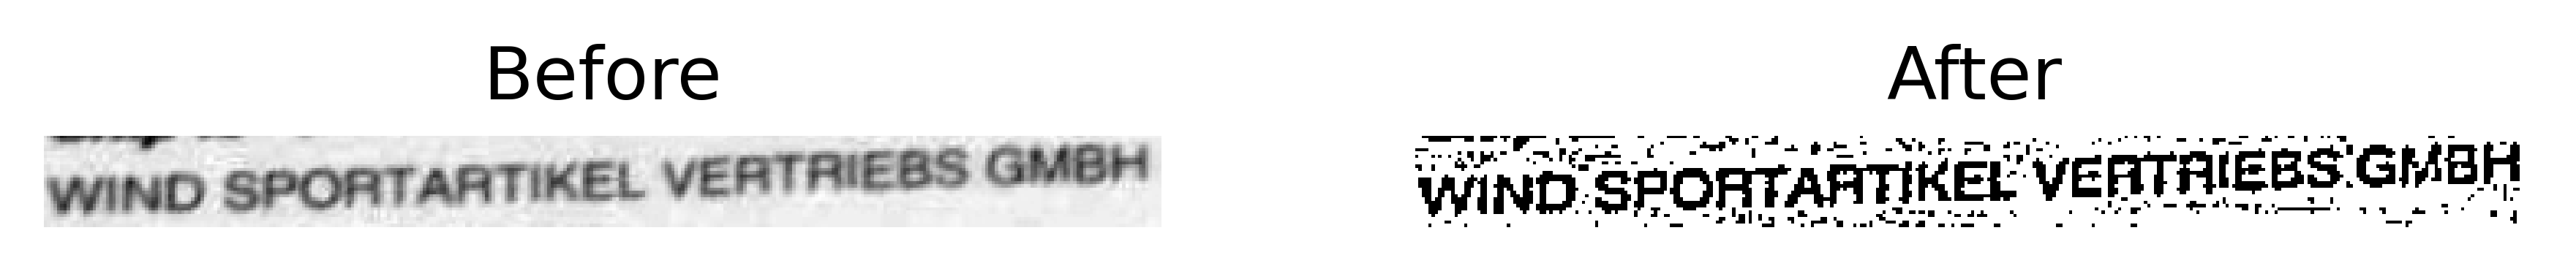

WIND SROR0AaTKEE VeQTAEESCKBR


In [106]:
imgf = cv2.adaptiveThreshold(img_bboxes[1],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7, 2) #imgf contains Binary image

plot_images(img_bboxes[1], imgf)
print(ocr.predict(image=imgf))

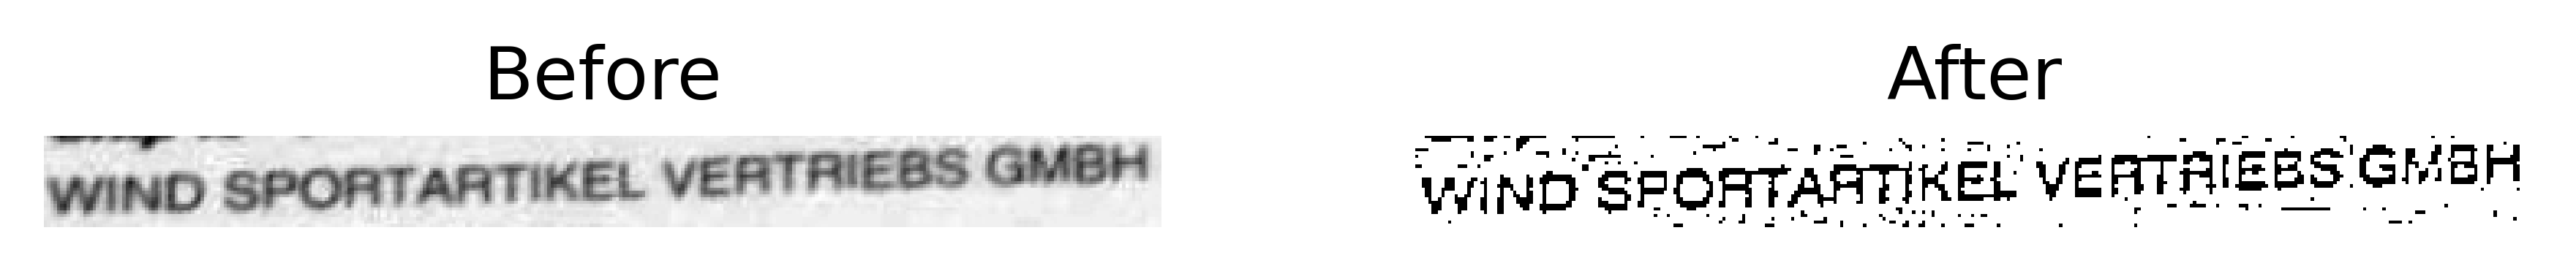

WIND "SpoRTAATKEL Vertaiebs GKBR


In [107]:
kernel = np.ones((1,2),np.uint8)
gray_negative = abs(255-imgf)
erosion = cv2.erode(gray_negative,kernel,iterations = 1)

plot_images(img_bboxes[1], abs(255-erosion))
print(ocr.predict(image=abs(255-erosion)))

In [108]:
print(ocr.predict(image=img_bboxes[1]))
print(ocr.predict(image=im, **config))

WINd SportaATIKEL Veatriebs GMBH
Ship {0 Wind SportartikEL Veatriebs GMBH FROSCHENGASSE 6 86111 SAARBRUCKEN Geamany


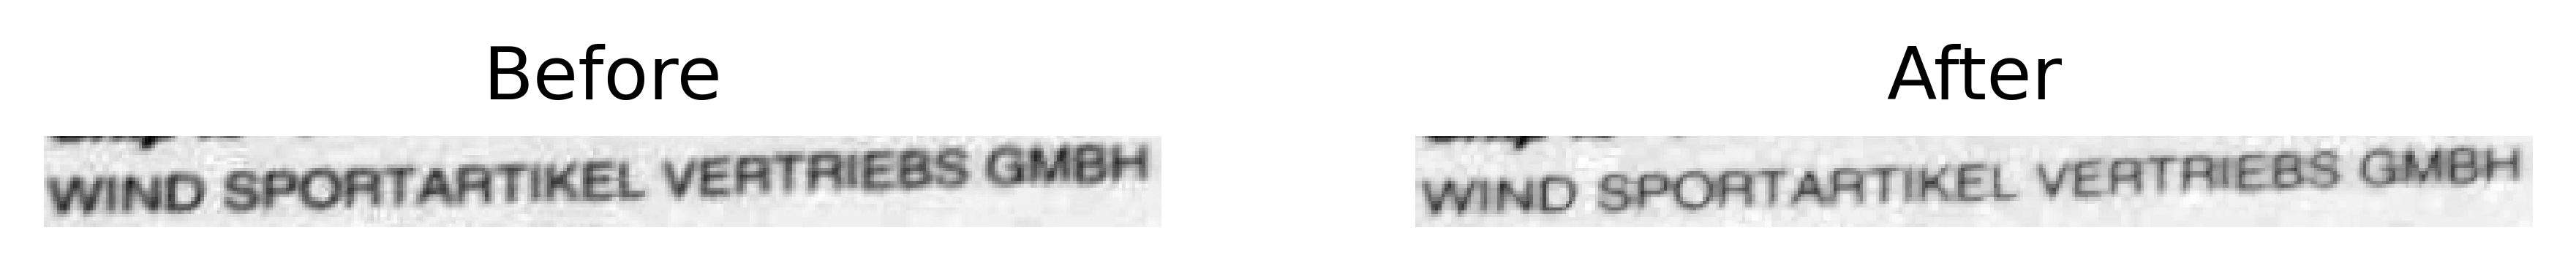

WINd SPOATAATIKEL VEATRIEBS GMBH


In [109]:
kernel = np.ones((2,2),np.uint8)
gray_negative = abs(255-img_bboxes[1])
erosion = cv2.erode(gray_negative,kernel,iterations = 1)

plot_images(img_bboxes[1], abs(255-erosion))
print(ocr.predict(image=abs(255-erosion)))

#### *Downsizing interpolation*

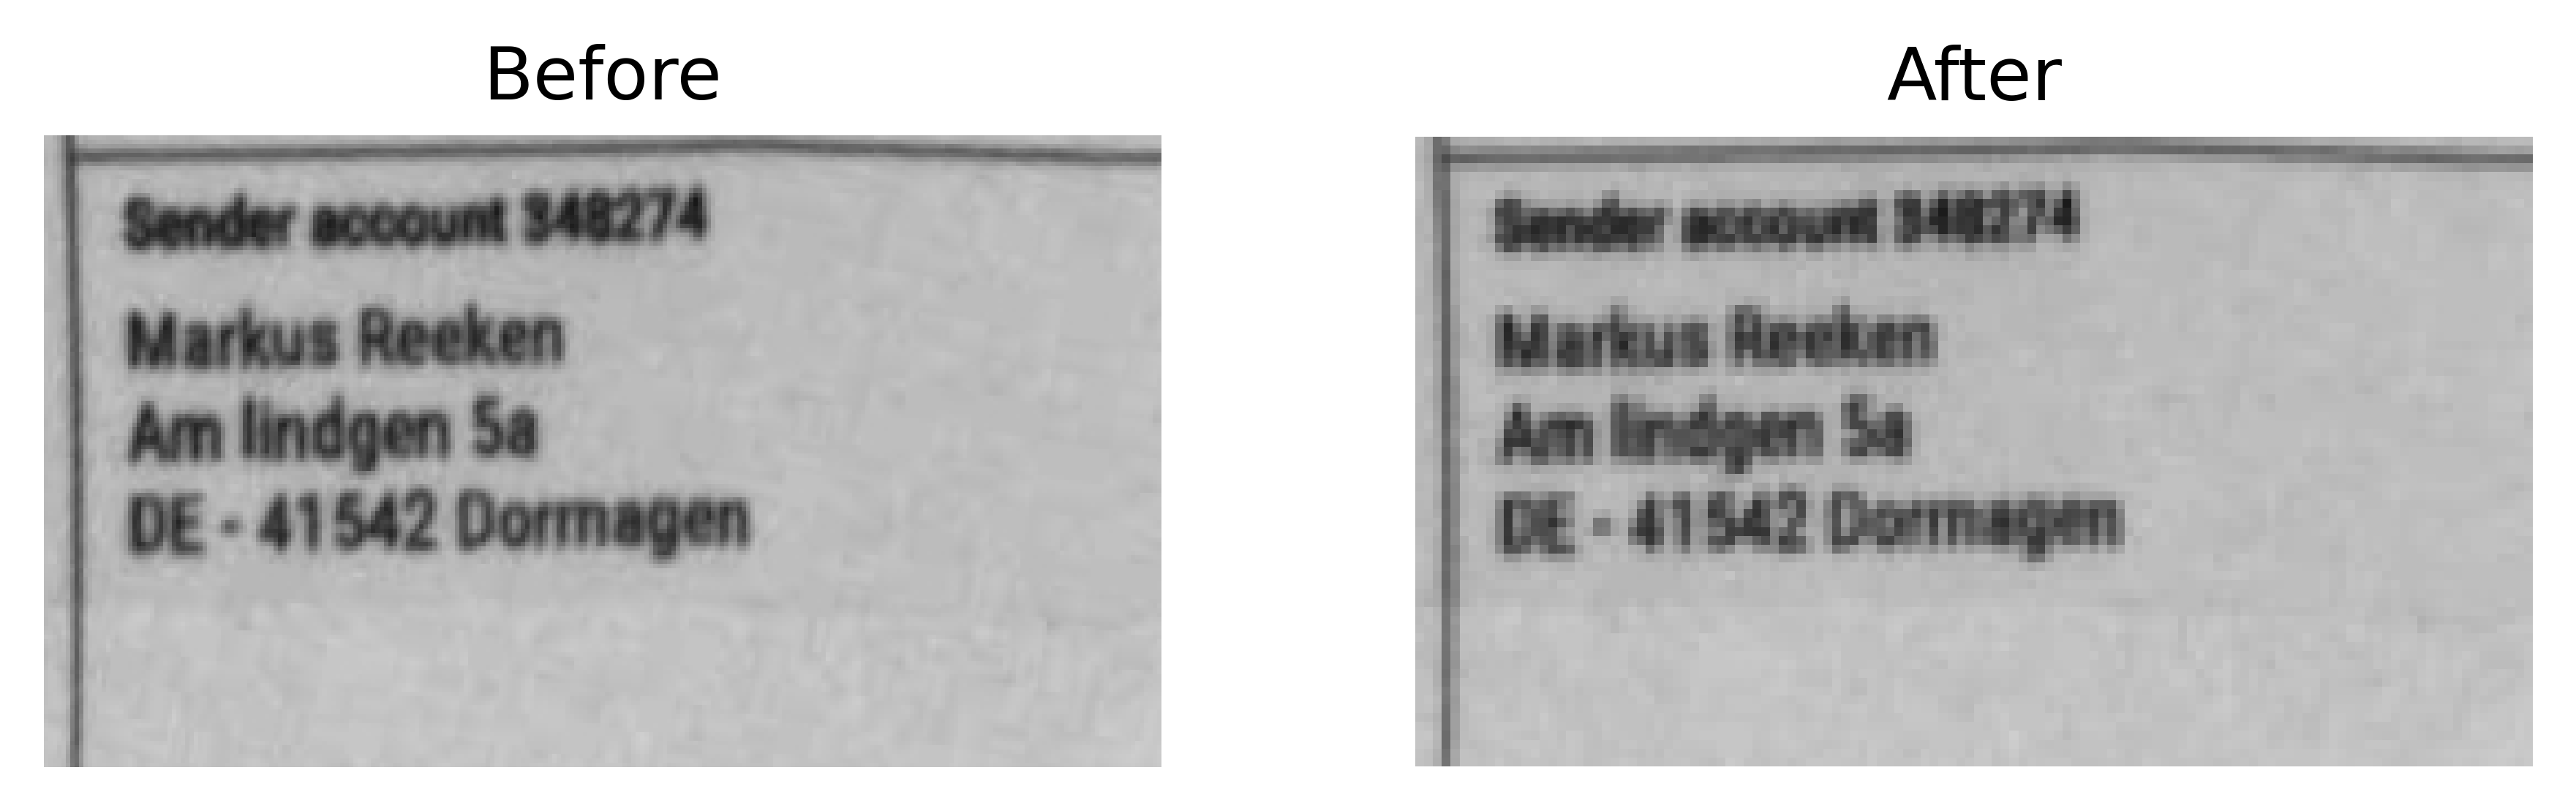

In [110]:
resized = cv2.resize(img, (int(img.shape[1]/2),int(img.shape[0]/2)), interpolation=cv2.INTER_LINEAR)

plot_images(img, resized)

## Super resolution

*Papers:*
- [Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial
Network](https://arxiv.org/pdf/1609.04802v5.pdf)
- [Review: SRGAN & SRResNet — Photo-Realistic Super Resolution](https://sh-tsang.medium.com/review-srgan-srresnet-photo-realistic-super-resolution-gan-super-resolution-96a6fa19490
)

#### *SRResNet*

Loss function: MixGE

> **MSE + λMGE** (Mean Gradient Error) 

with λ = 2.1


In [111]:
import torch
import torch_enhance
from torch import nn

# increase resolution by factor of 2 (e.g. 128x128 -> 256x256)
model = torch_enhance.models.SRResNet(scale_factor=2, channels=1)

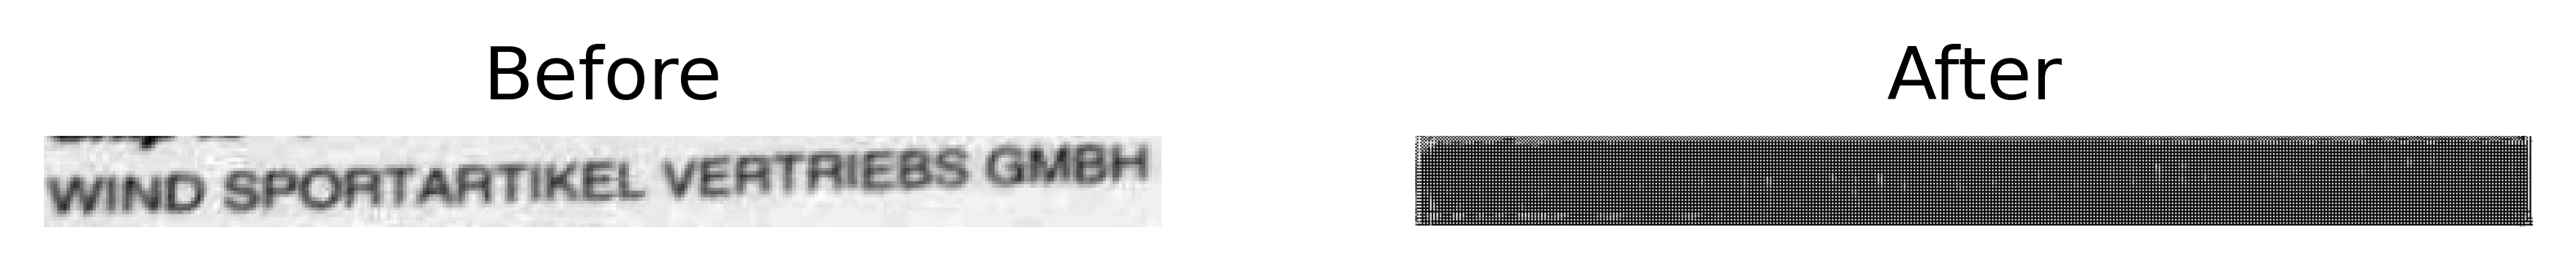

In [112]:
im_lr = img_bboxes[1].copy()
im_lr = im_lr.reshape(1, *im_lr.shape, 1)

lr = torch.tensor(im_lr, dtype=torch.float32)
lr = lr.permute((0,3,1,2))

sr = model(lr) # [1, 3, 256, 256]

img_sr = sr.permute(0,2,3,1).detach().numpy()

plot_images(im_lr[0], img_sr[0])

In [113]:
image_name = '54074.jpg'

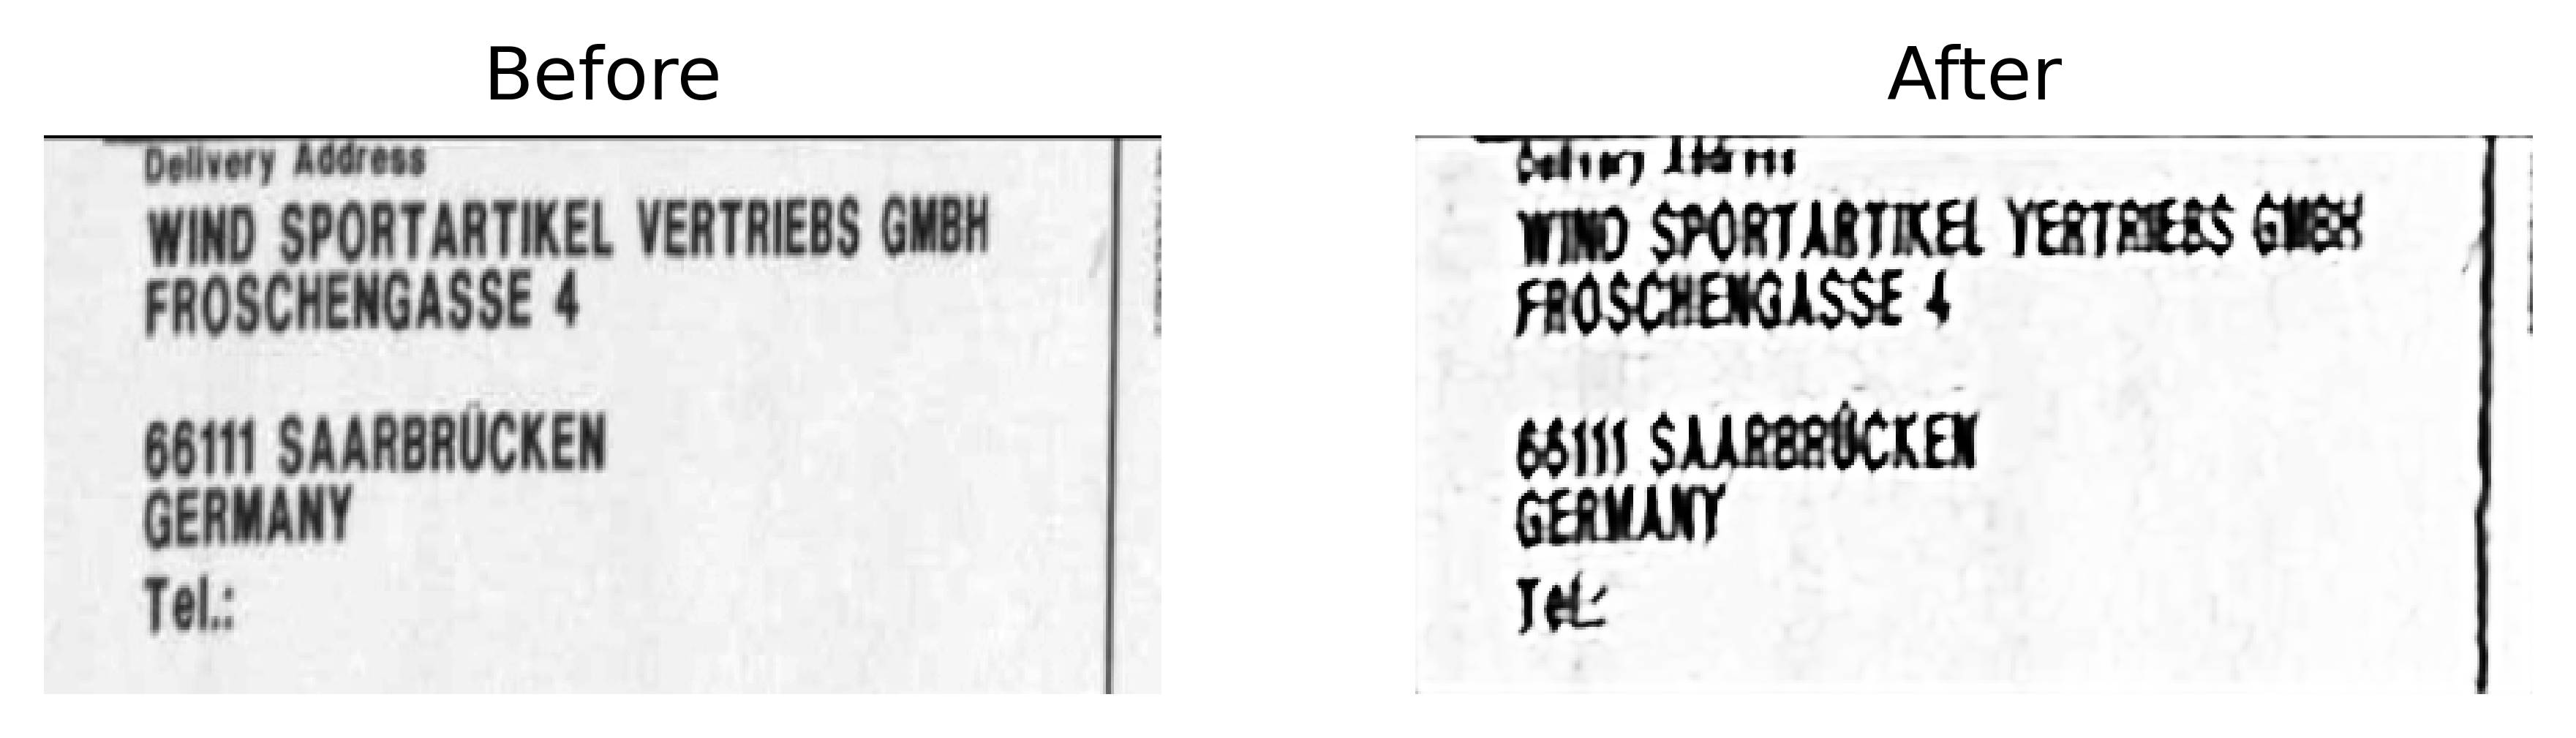

In [114]:
weight = torch.load('../txt_super_res/checkpoints_saved/00_checkpoint_465.pkl', map_location=torch.device('cuda'))

model = SRResNetModel(2,1)
model = nn.DataParallel(model)
model.load_state_dict(weight['model'])
model = model.requires_grad_(False).to('cuda')

with torch.no_grad():
    lr = cv2.imread(IMAGES_PATH + image_name, cv2.IMREAD_GRAYSCALE)
    lr = cv2.resize(lr,(400,200), interpolation=cv2.INTER_AREA)
    lr = torch.from_numpy(lr).type(torch.float32).cuda()
    lr = lr.reshape((1,1,*lr.shape))/255

    sr = model(lr) # [1, 1, 800, 400]

    im_sr = sr.cpu().numpy().transpose([0, 2, 3, 1])
    im_lr = lr.cpu().numpy().transpose([0, 2, 3, 1])
    plot_images(im_lr[0], im_sr[0])

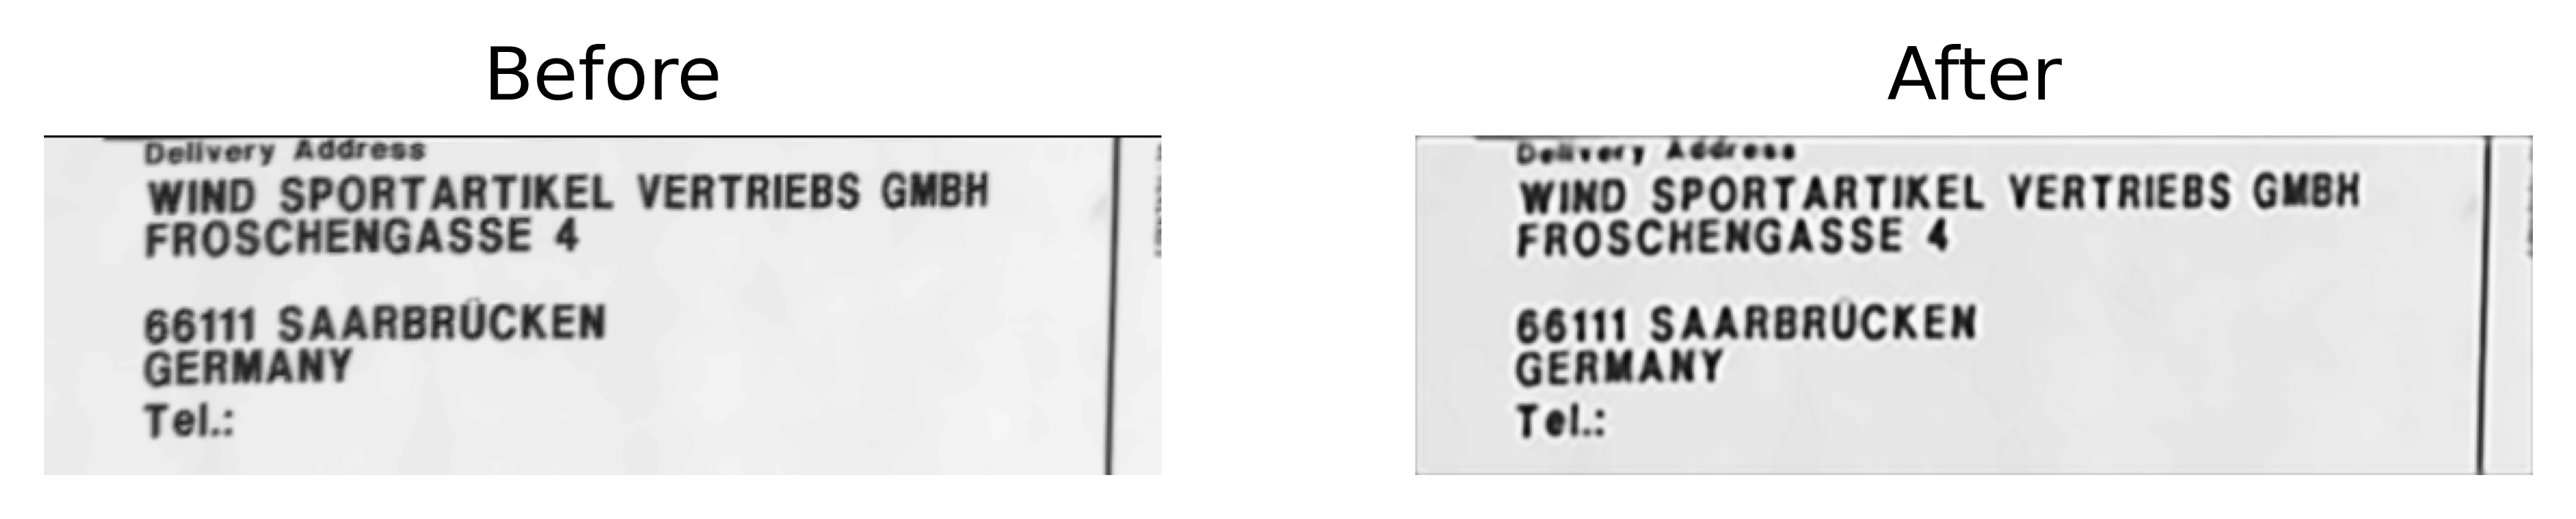

In [115]:
weight = torch.load('../txt_super_res/checkpoints/checkpoint_1000.pkl', map_location=torch.device('cuda'))

model = SRResNetModel(2,1)
model = nn.DataParallel(model)
model.load_state_dict(weight['model'])
model = model.requires_grad_(False).to('cuda')

with torch.no_grad():
    lr = cv2.imread(IMAGES_PATH + image_name, cv2.IMREAD_COLOR)
    lr = cv2.fastNlMeansDenoisingColored(lr, None, 7, 7, 4, 15) 
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2GRAY)
    lr = torch.from_numpy(lr).type(torch.float32).cuda()
    lr = lr.reshape((1,1,*lr.shape))/255

    sr = model(lr) # [1, 1, 800, 400]

    im_sr = sr.cpu().numpy().transpose([0, 2, 3, 1])
    im_lr = lr.cpu().numpy().transpose([0, 2, 3, 1])
    plot_images(im_lr[0], im_sr[0])

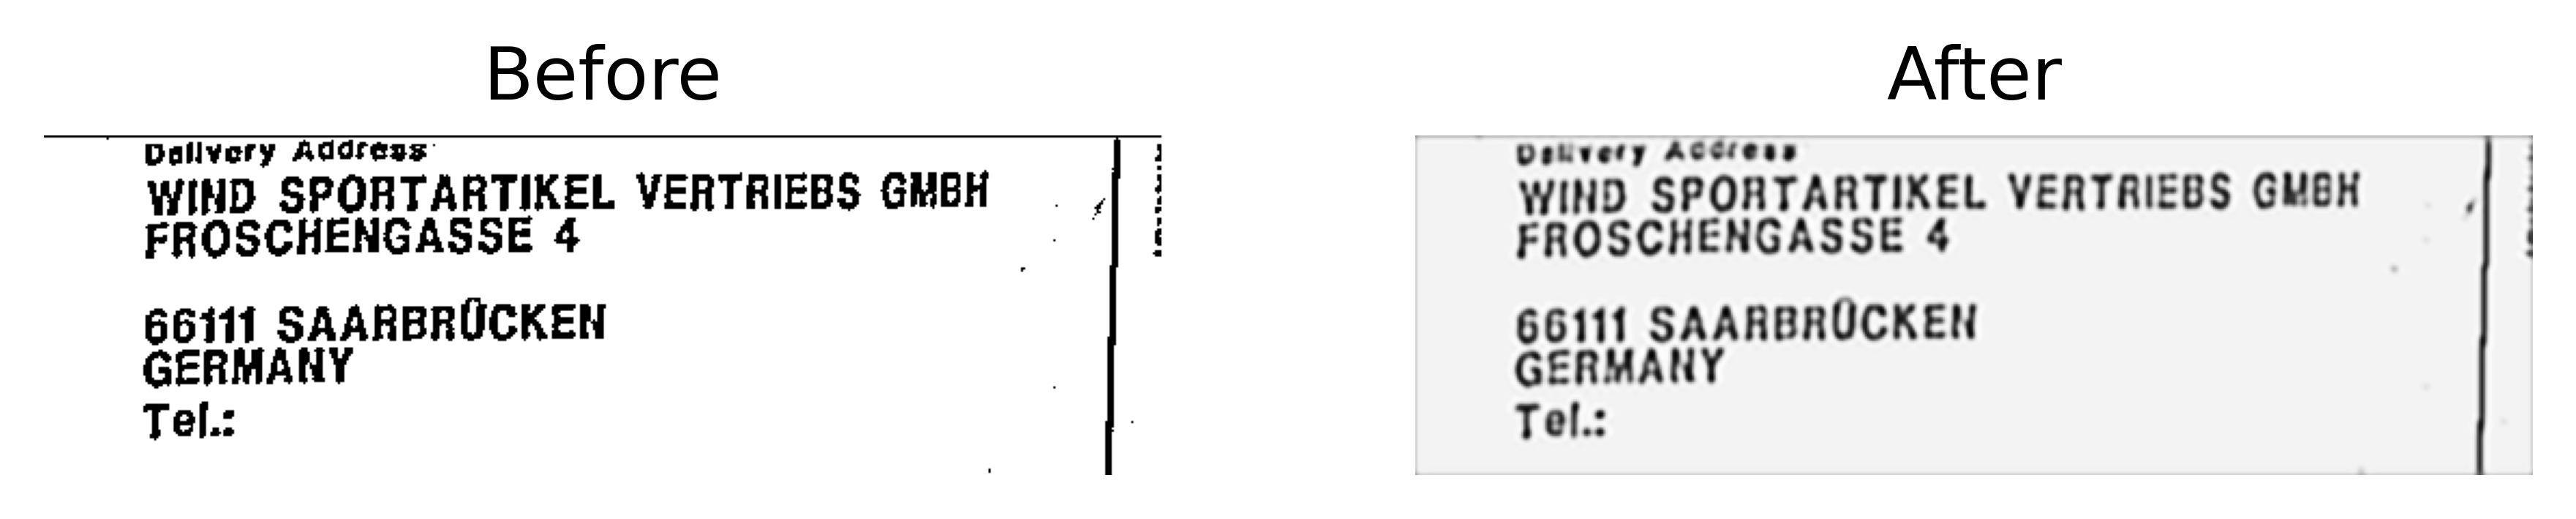

In [116]:
weight = torch.load('../txt_super_res/checkpoints/checkpoint_1000.pkl', map_location=torch.device('cuda'))

model = SRResNetModel(2,1)
model = nn.DataParallel(model)
model.load_state_dict(weight['model'])
model = model.requires_grad_(False).to('cuda')

with torch.no_grad():
    lr = cv2.imread(IMAGES_PATH + image_name, cv2.IMREAD_COLOR)
    lr = cv2.fastNlMeansDenoisingColored(lr, None, 7, 7, 4, 15) 
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2GRAY)
    lr = cv2.adaptiveThreshold(lr,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7,2) #imgf contains Binary image
    lr = torch.from_numpy(lr).type(torch.float32).cuda()
    lr = lr.reshape((1,1,*lr.shape))/255

    sr = model(lr) # [1, 1, 800, 400]

    im_sr = sr.cpu().numpy().transpose([0, 2, 3, 1])
    im_lr = lr.cpu().numpy().transpose([0, 2, 3, 1])
    plot_images(im_lr[0], im_sr[0])

In [117]:
img_0 = cv2.normalize(im_lr[0], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
img_1 = cv2.normalize(im_sr[0], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

In [118]:
print(ocr.predict(image=img_0, **config))
print(ocr.predict(image=img_1, **config))

k FINE5E Heht Najery La Jeleoea |#e |snanuenck 2  Ehe Slaenan@Adm 2 U Ieleen3 #Wn
Seea Meaeeeae Ueen Seeee E Jeene  deee eee Raee


## Blurred Img classification model (BIC)

### Detection des blocs avec easyOCR

In [197]:
box = []
for img_name in images:
    img = cv2.imread(os.path.join(IMAGES_PATH, img_name), cv2.IMREAD_GRAYSCALE)

    res = ocr.model.detect(
        img=img,
        min_size=7,
        low_text=0.5,
        width_ths=0.2
    )
    
    for i in extract_bboxes(res[0][0],img, 6):
        box.append(i)

[17, 153, 11, 29]
[17, 121, 37, 55]
[17, 43, 61, 75]
[41, 115, 57, 77]
[17, 39, 79, 97]
[45, 163, 77, 98]
[21, 69, 27, 43]
[71, 186, 15, 43]
[18, 142, 48, 74]
[17, 138, 69, 98]
[21, 47, 101, 119]
[56, 226, 89, 118]
[17, 59, 5, 21]
[61, 81, 7, 19]
[17, 67, 27, 43]
[70, 201, 21, 42]
[204, 301, 17, 38]
[303, 357, 17, 33]
[15, 178, 42, 66]
[17, 69, 71, 87]
[71, 206, 62, 86]
[18, 109, 88, 109]
[115, 177, -1, 11]
[45, 109, 3, 17]
[45, 99, 17, 37]
[106, 265, 14, 38]
[270, 380, 14, 38]
[385, 439, 15, 35]
[43, 230, 31, 60]
[43, 101, 77, 97]
[104, 264, 72, 98]
[42, 142, 97, 117]
[43, 91, 121, 141]


### Classification

In [198]:
len(box)

33

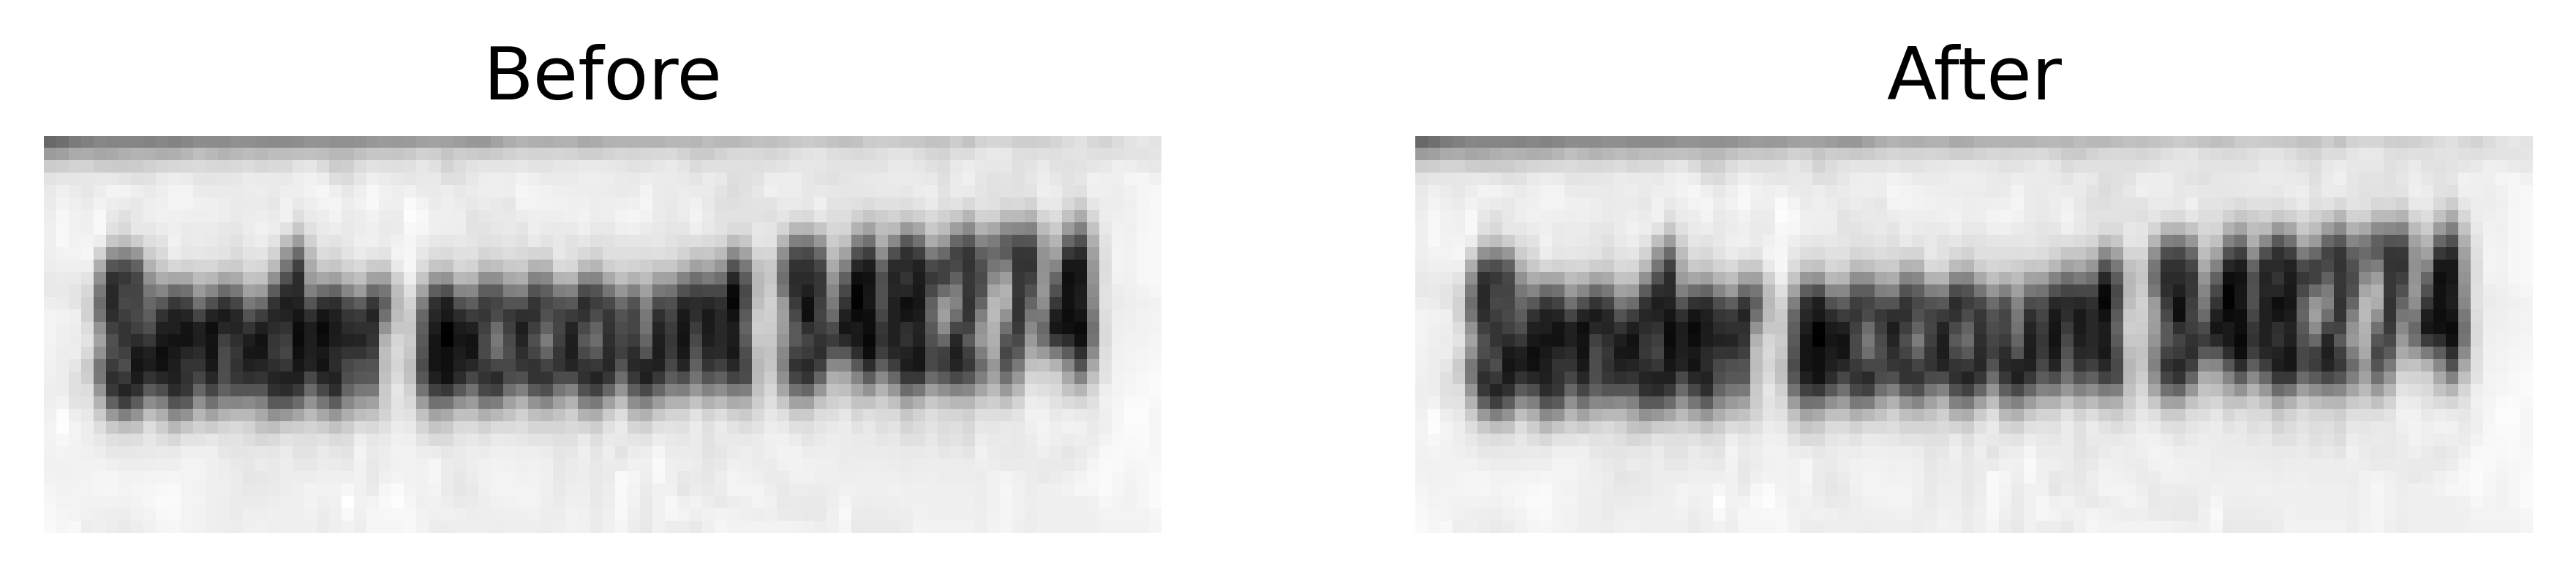

shipper 0.4851384162902832


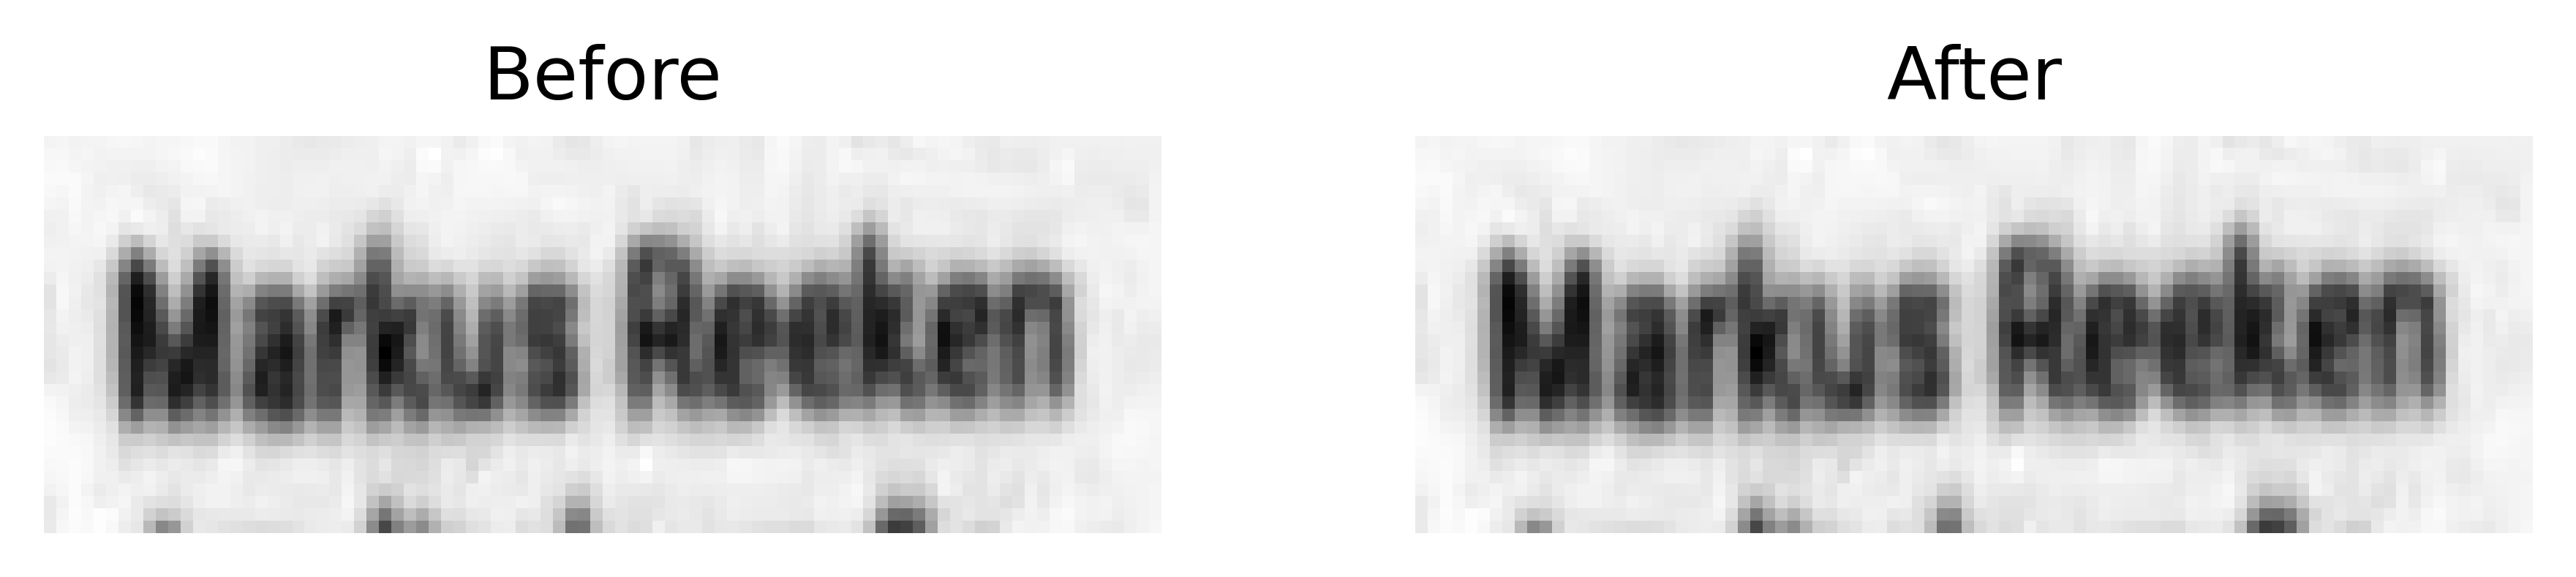

shipper 0.49882134795188904


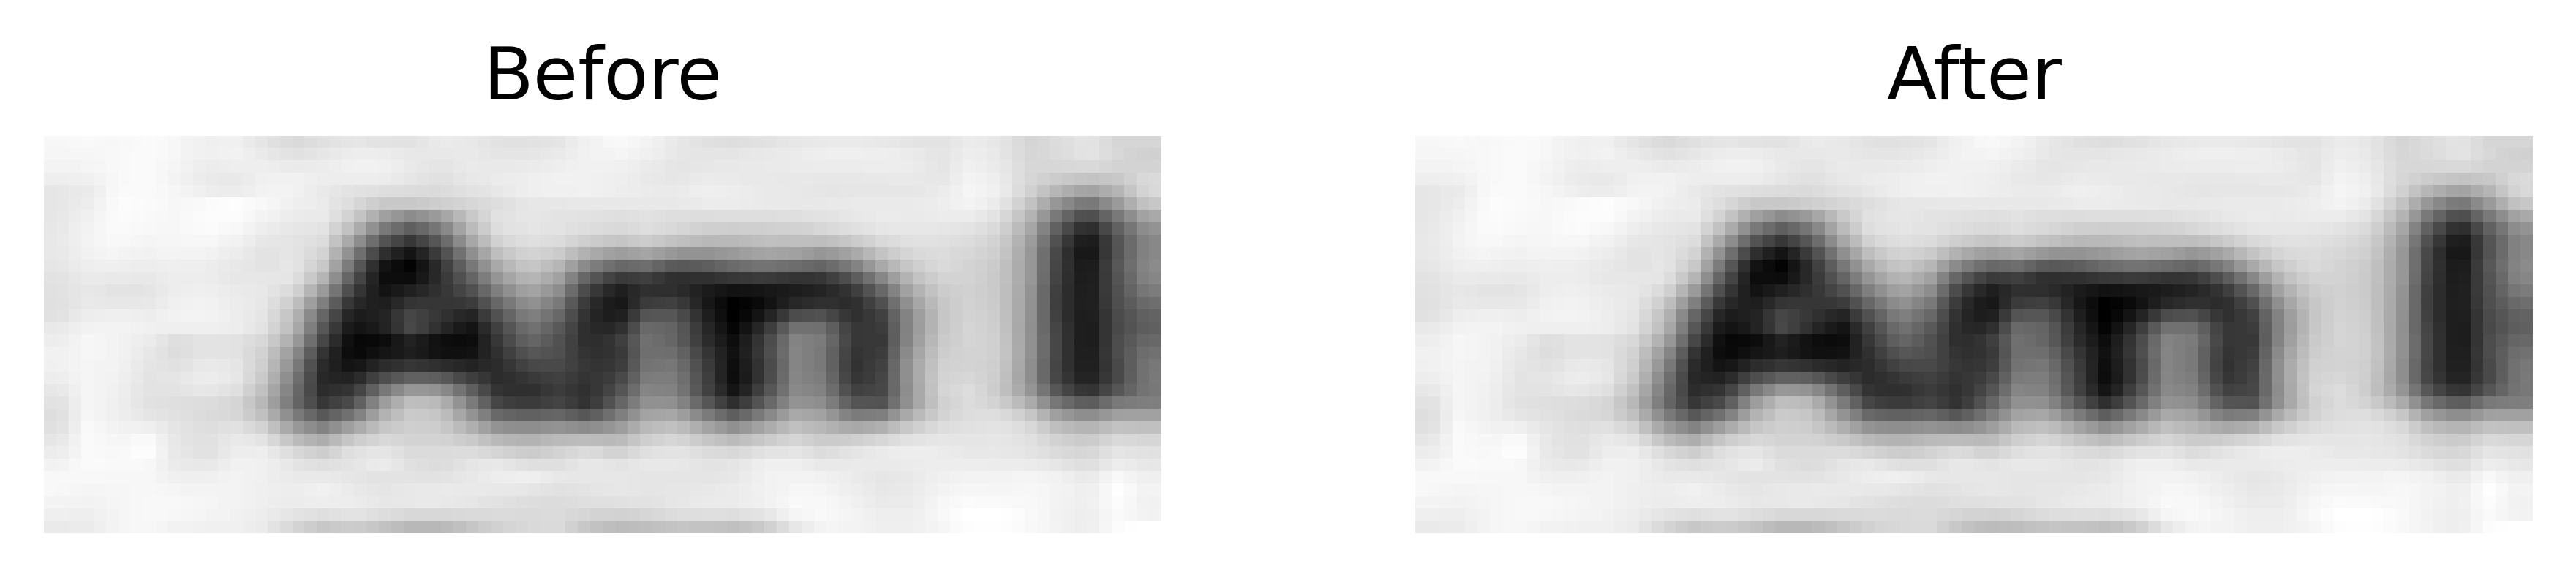

shipper 0.34578704833984375


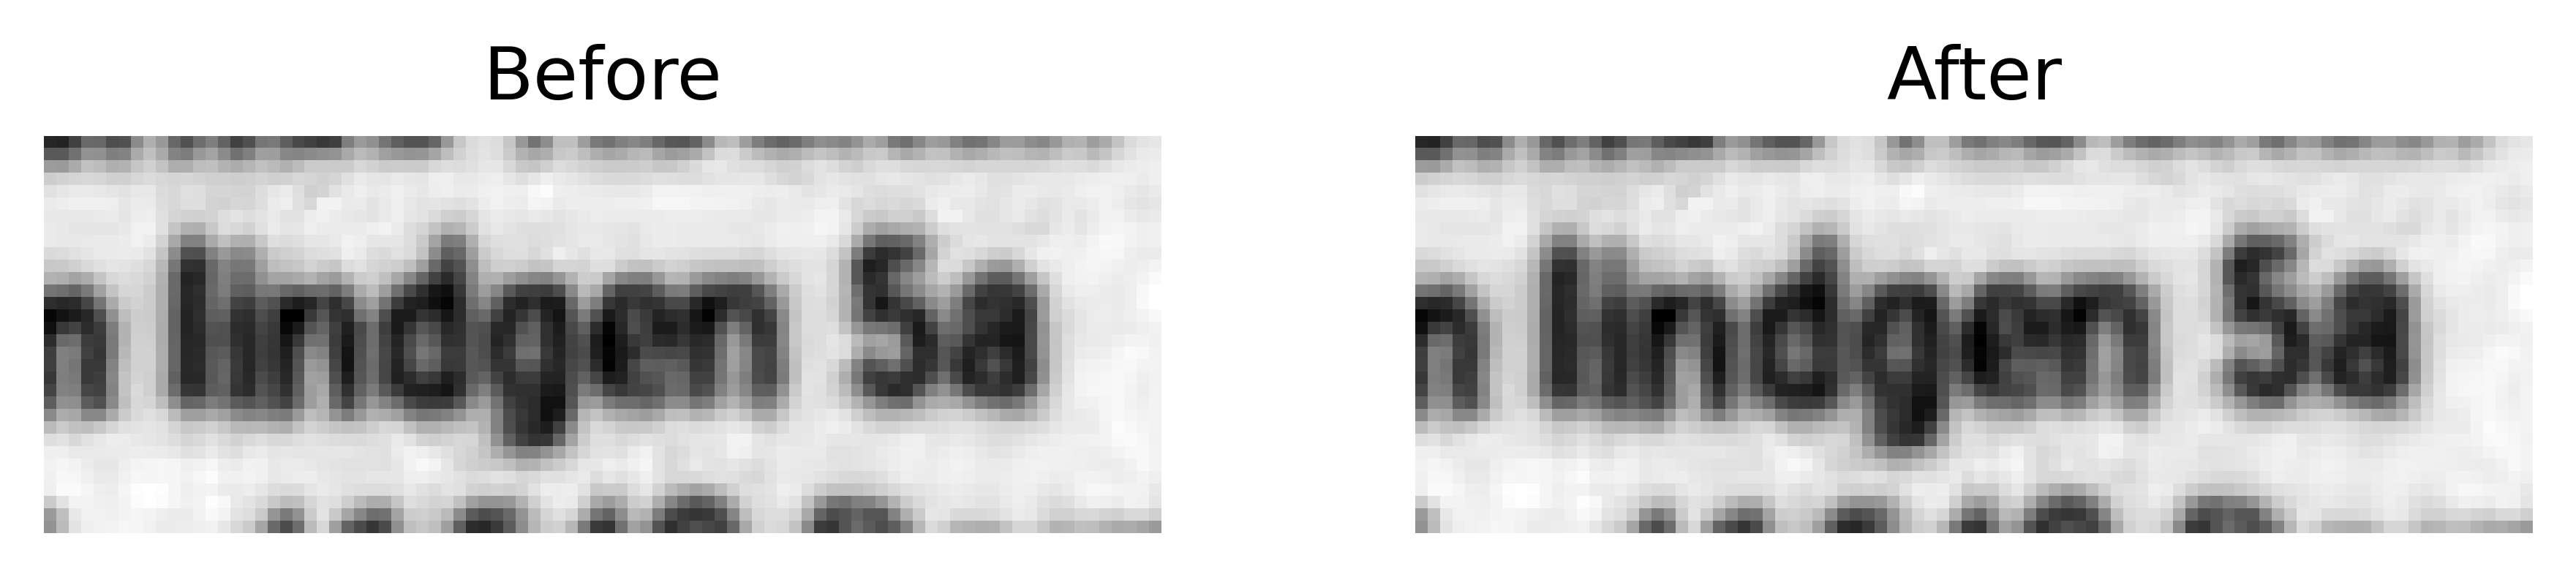

receiver 0.5092828869819641


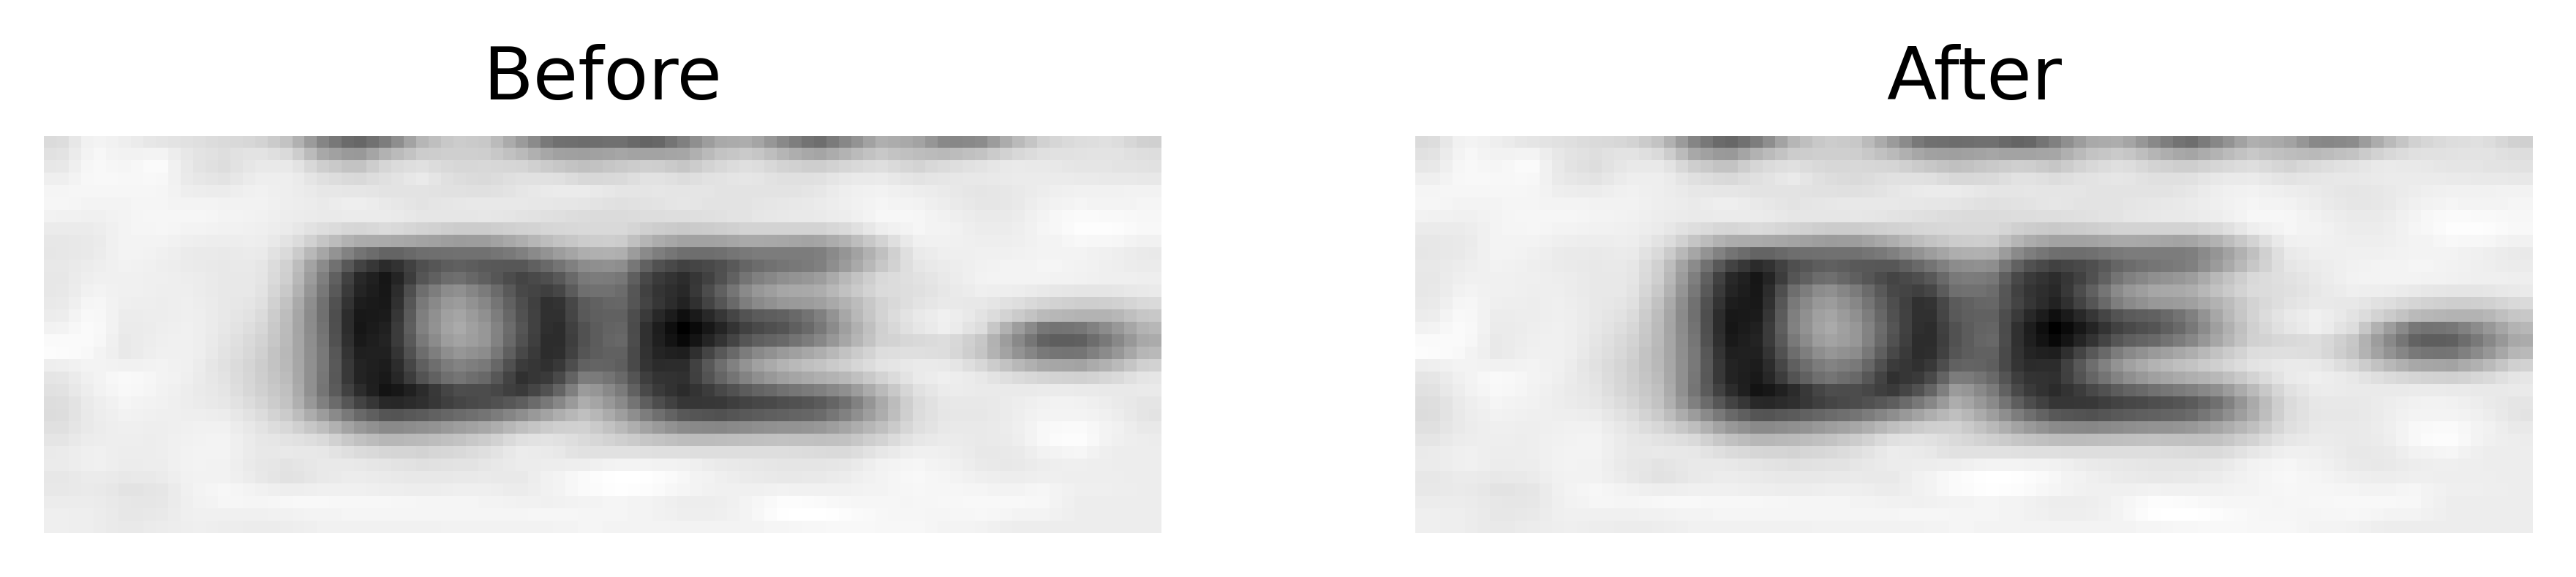

shipper 0.5857087969779968


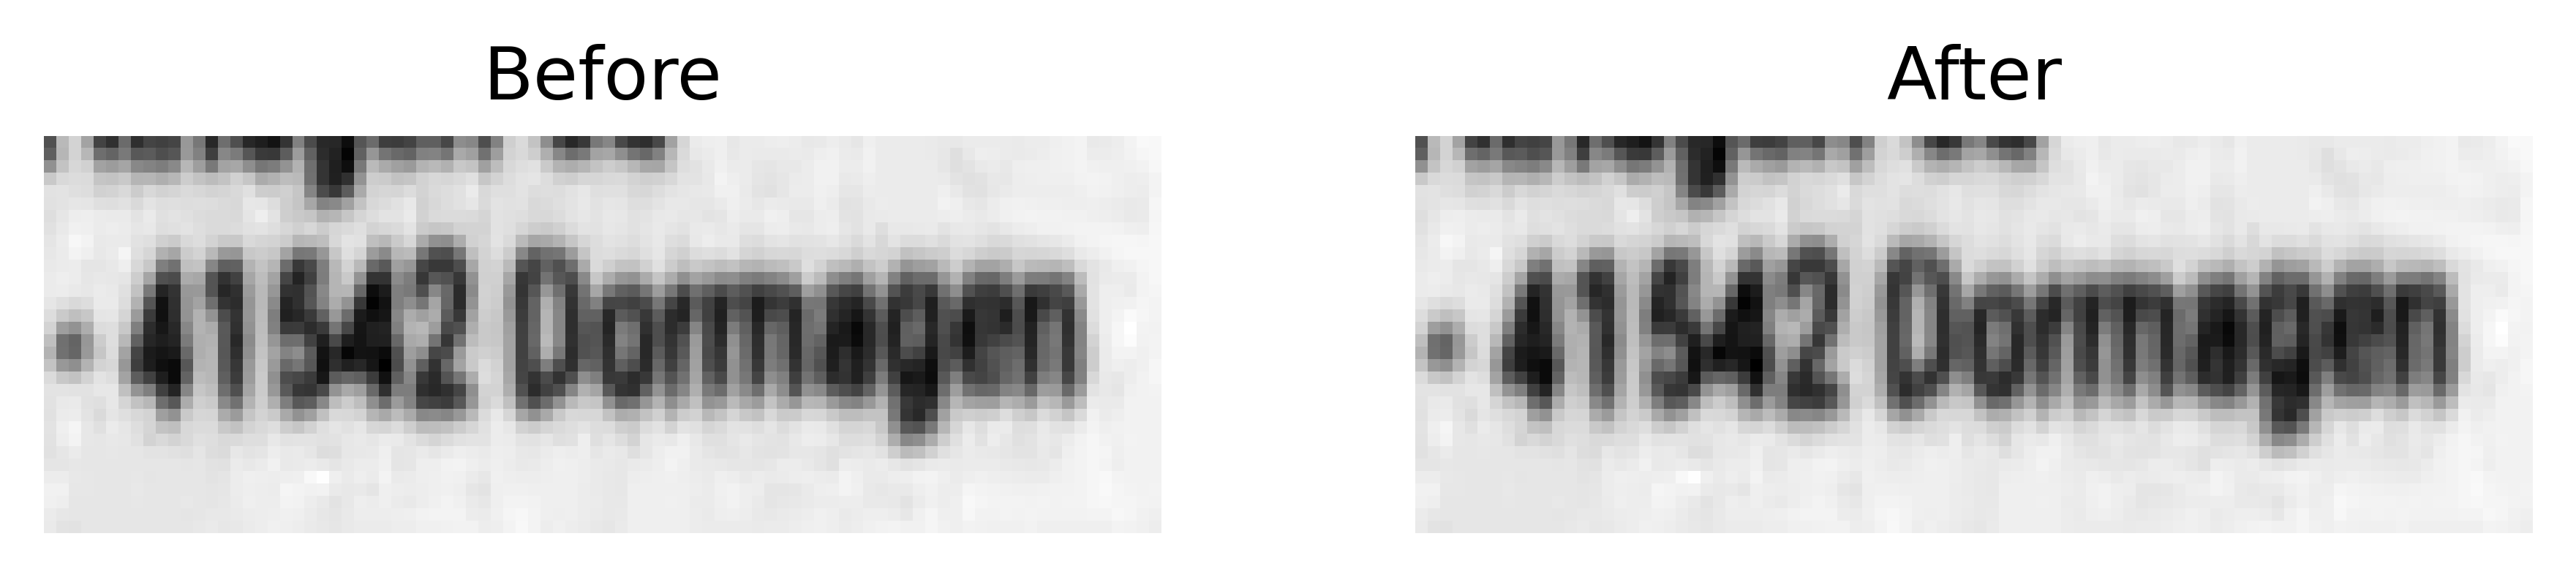

other 0.5847013592720032


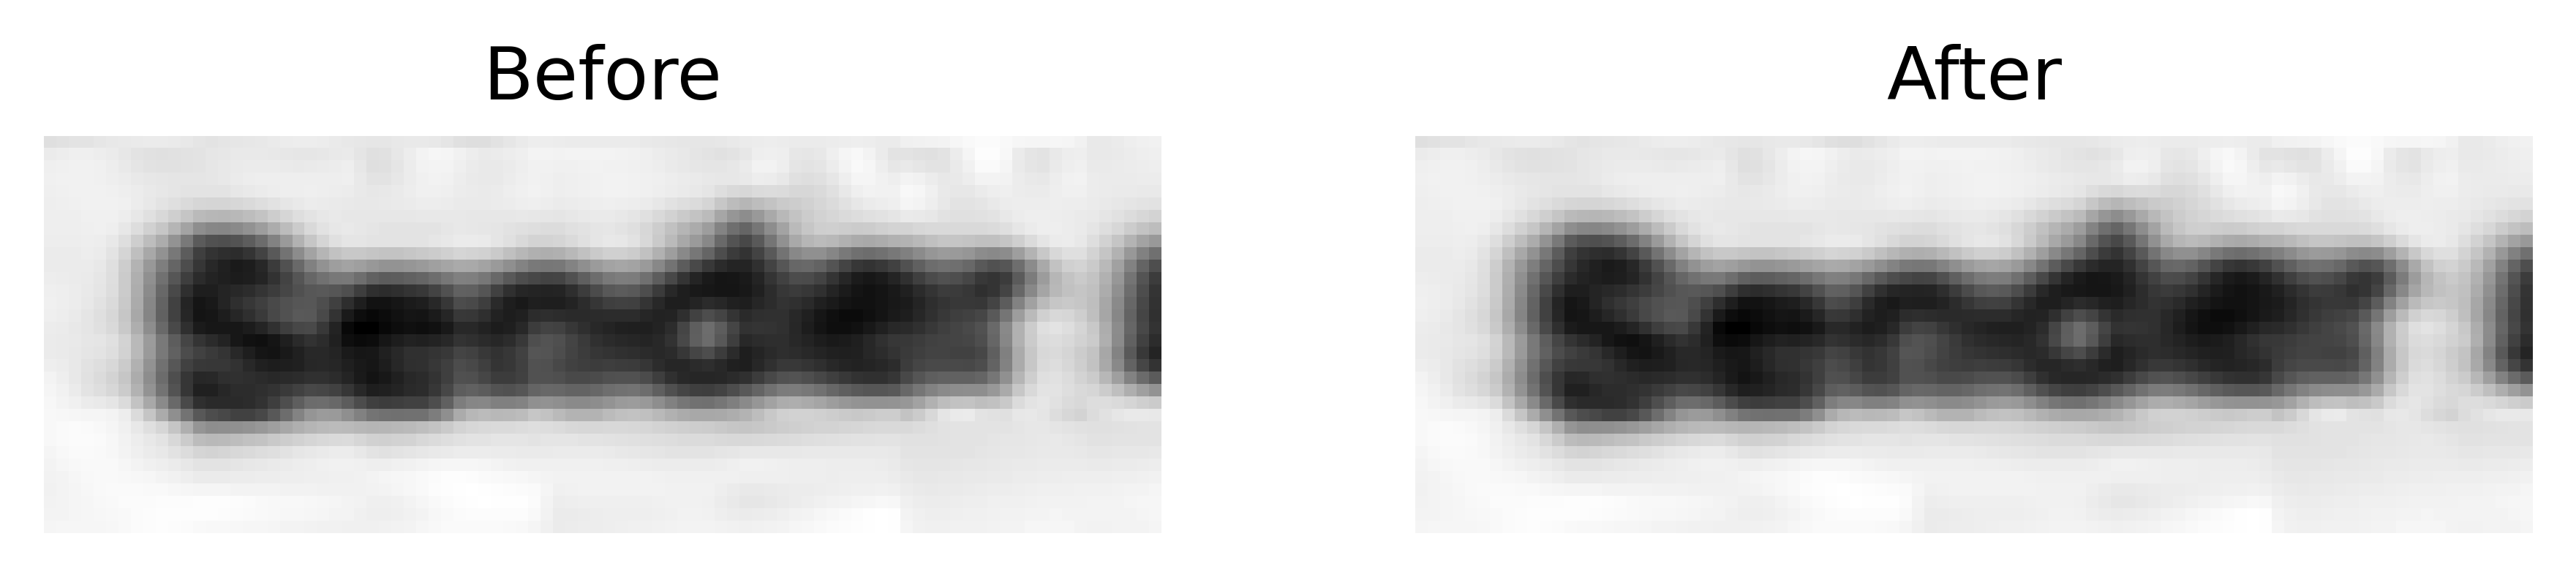

other 0.8218965530395508


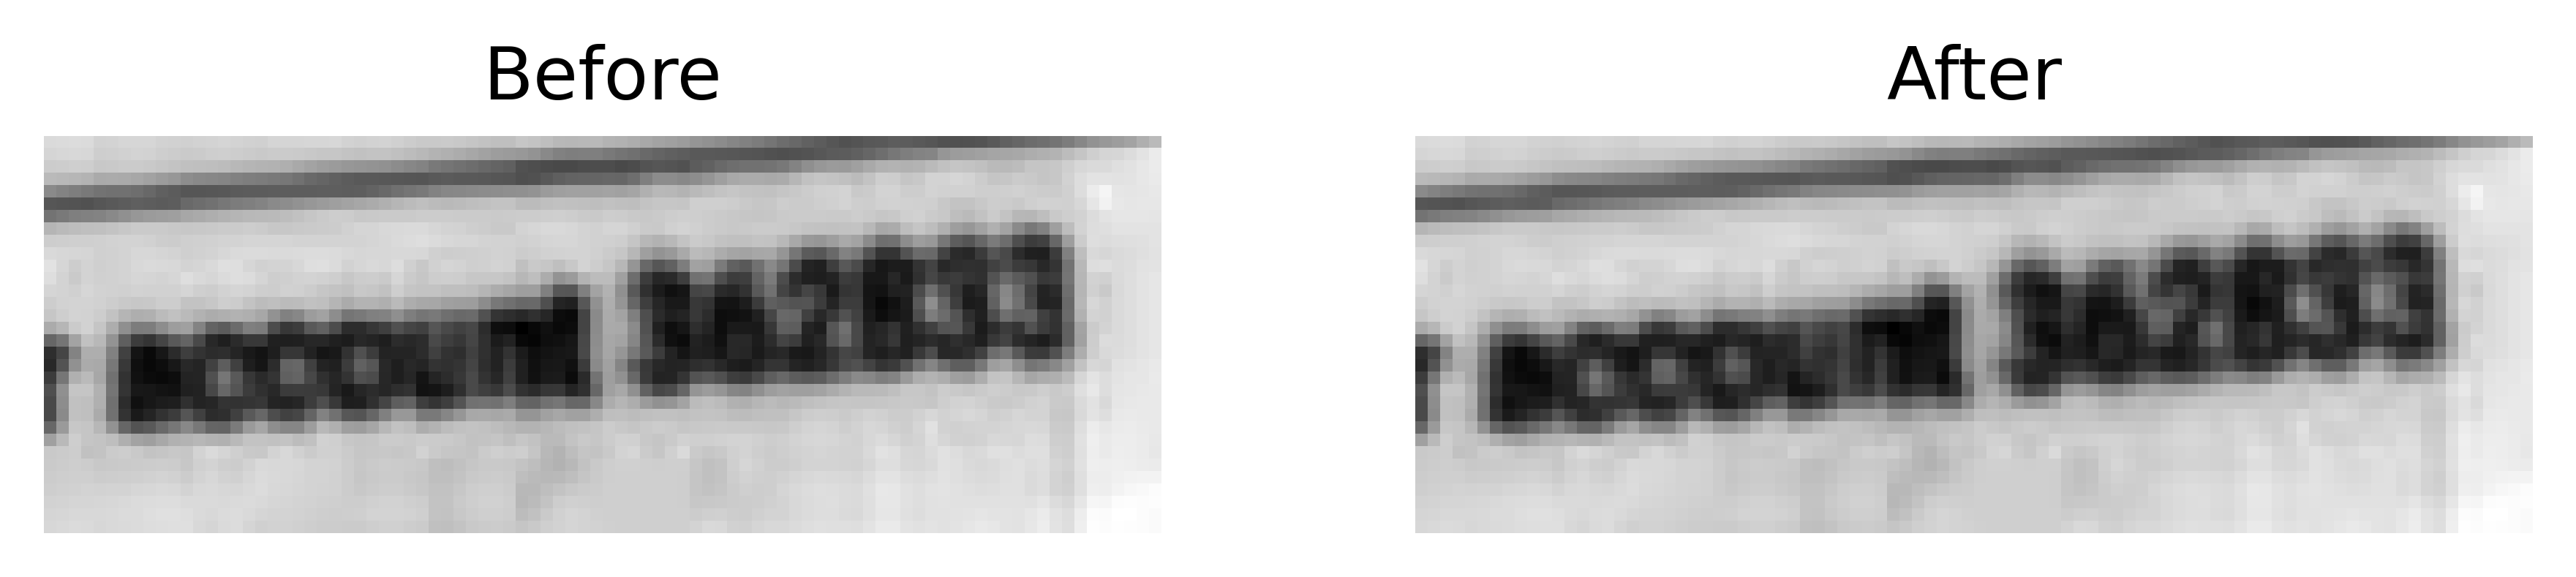

shipper 0.37004554271698


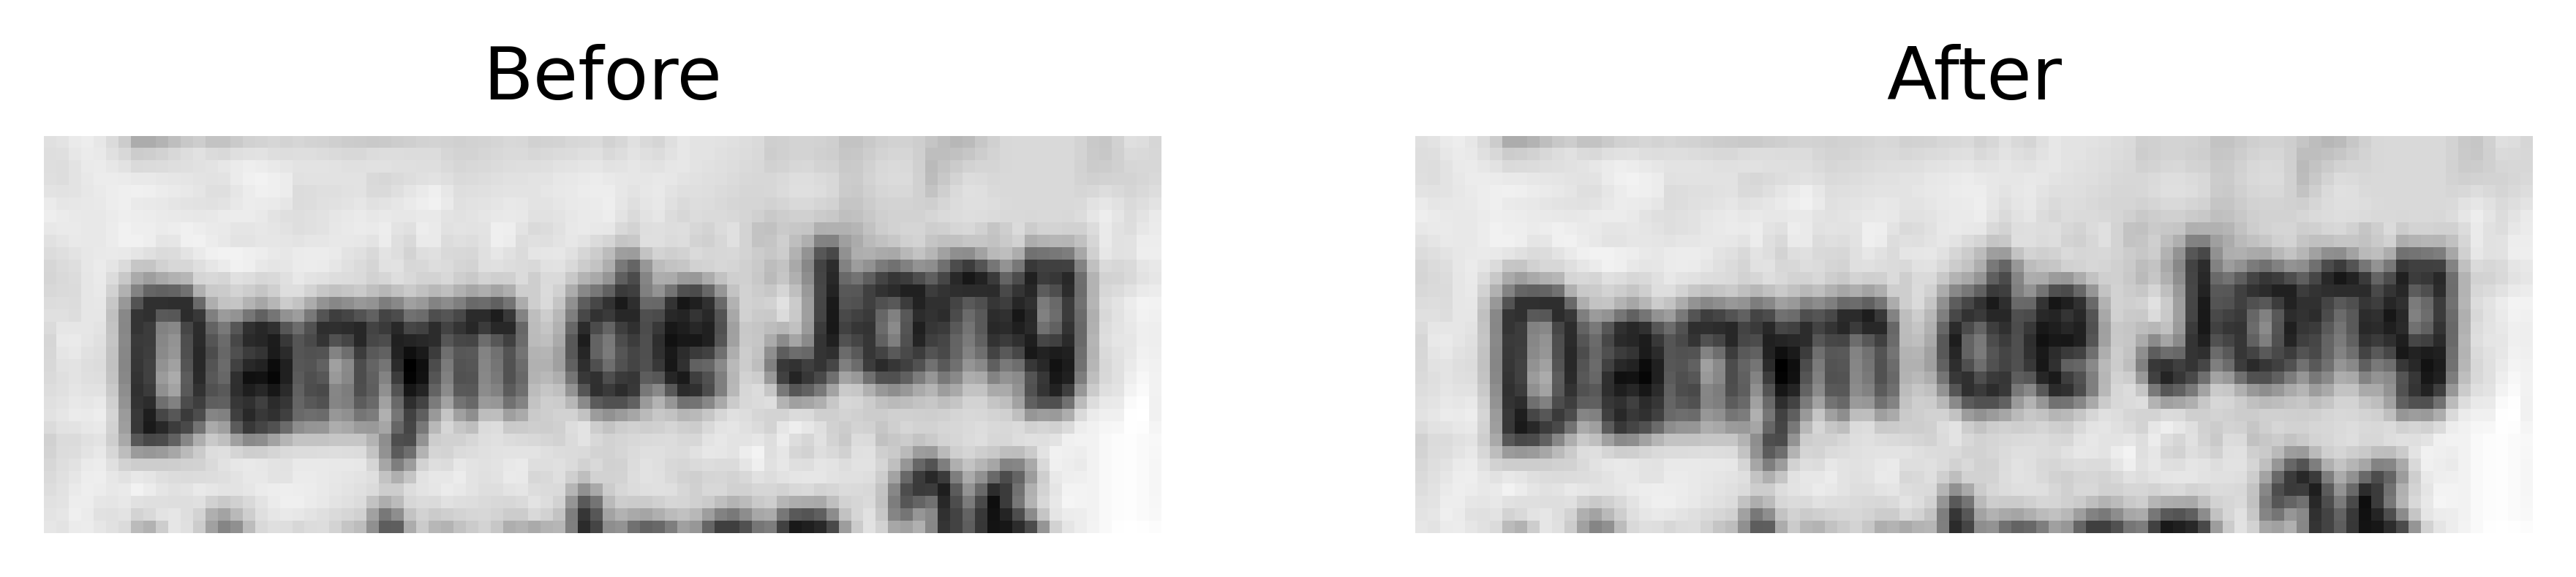

other 0.5275380611419678


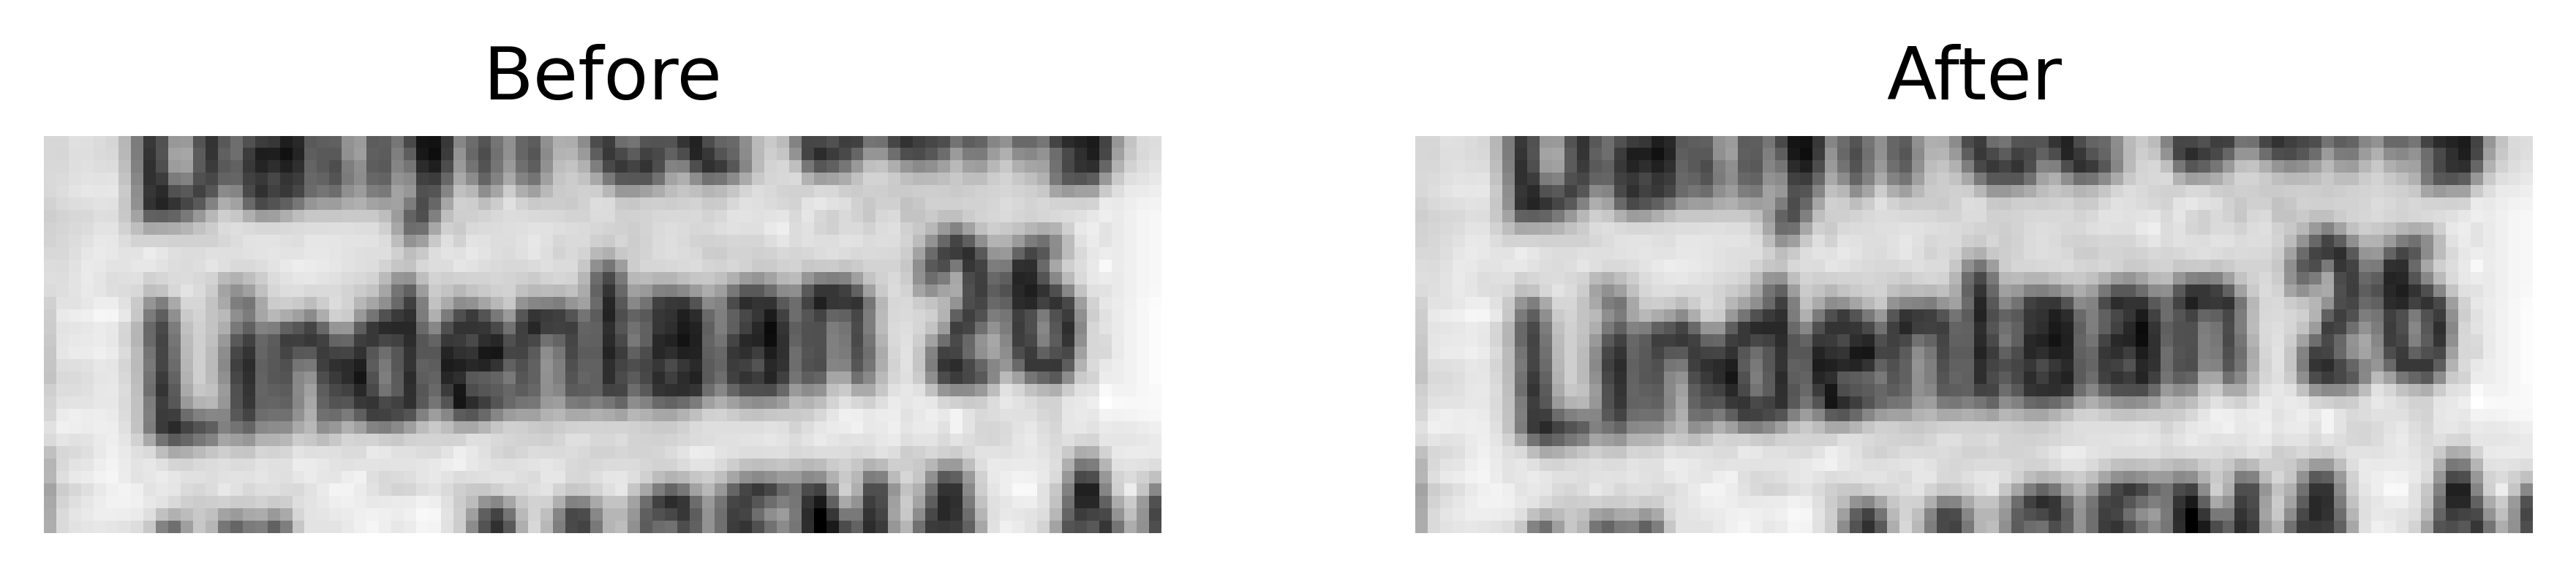

other 0.8332110643386841


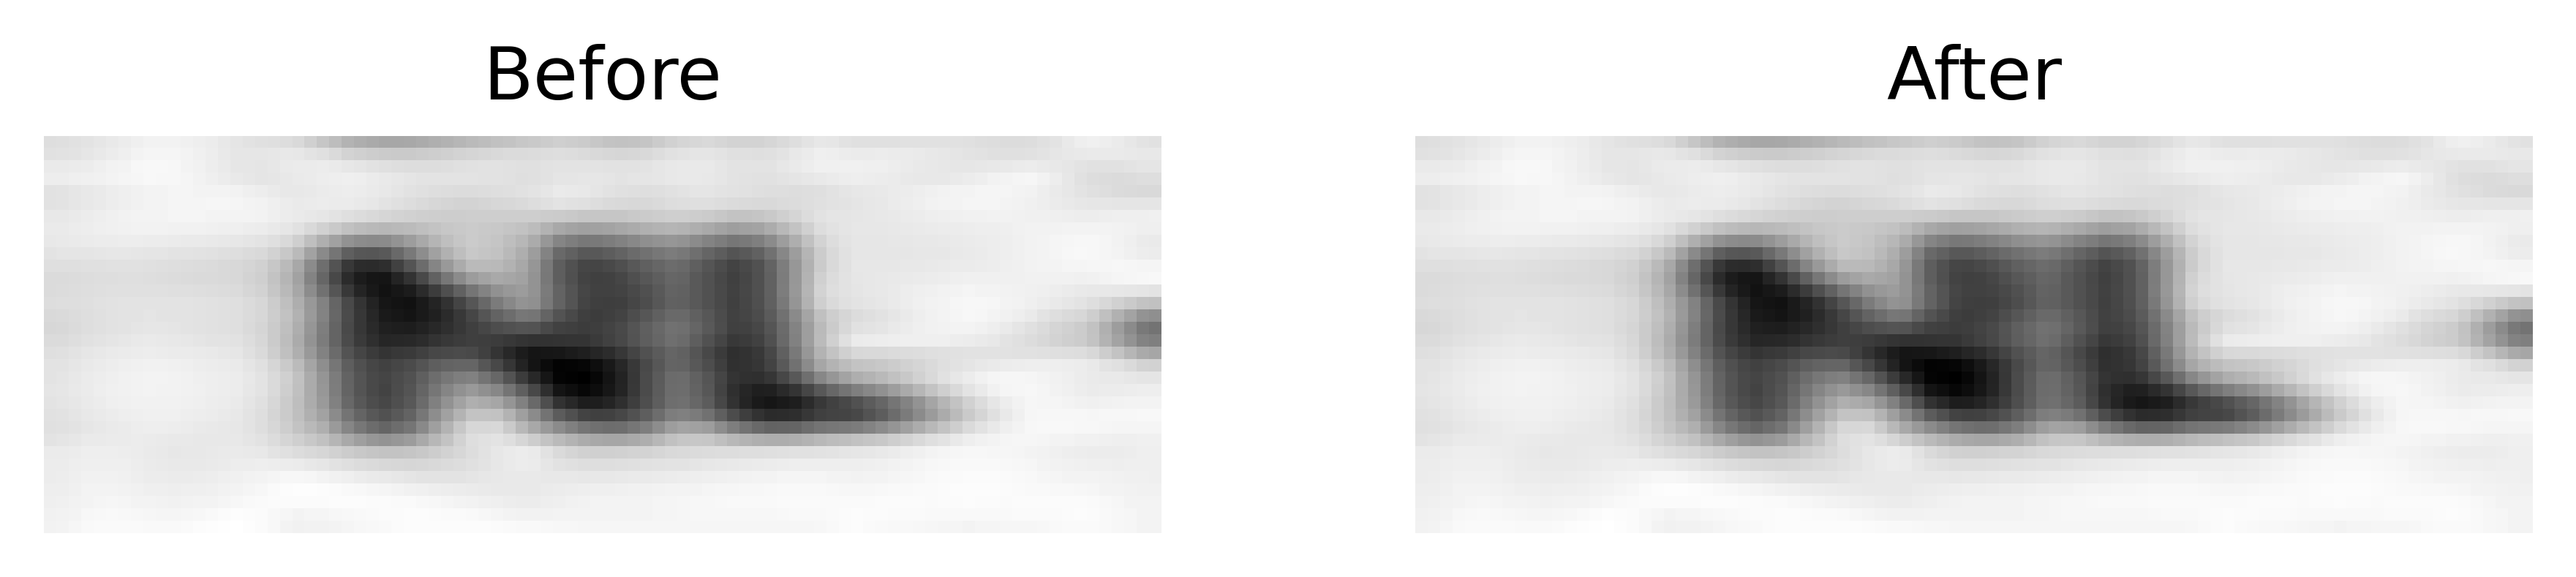

other 0.5832849144935608


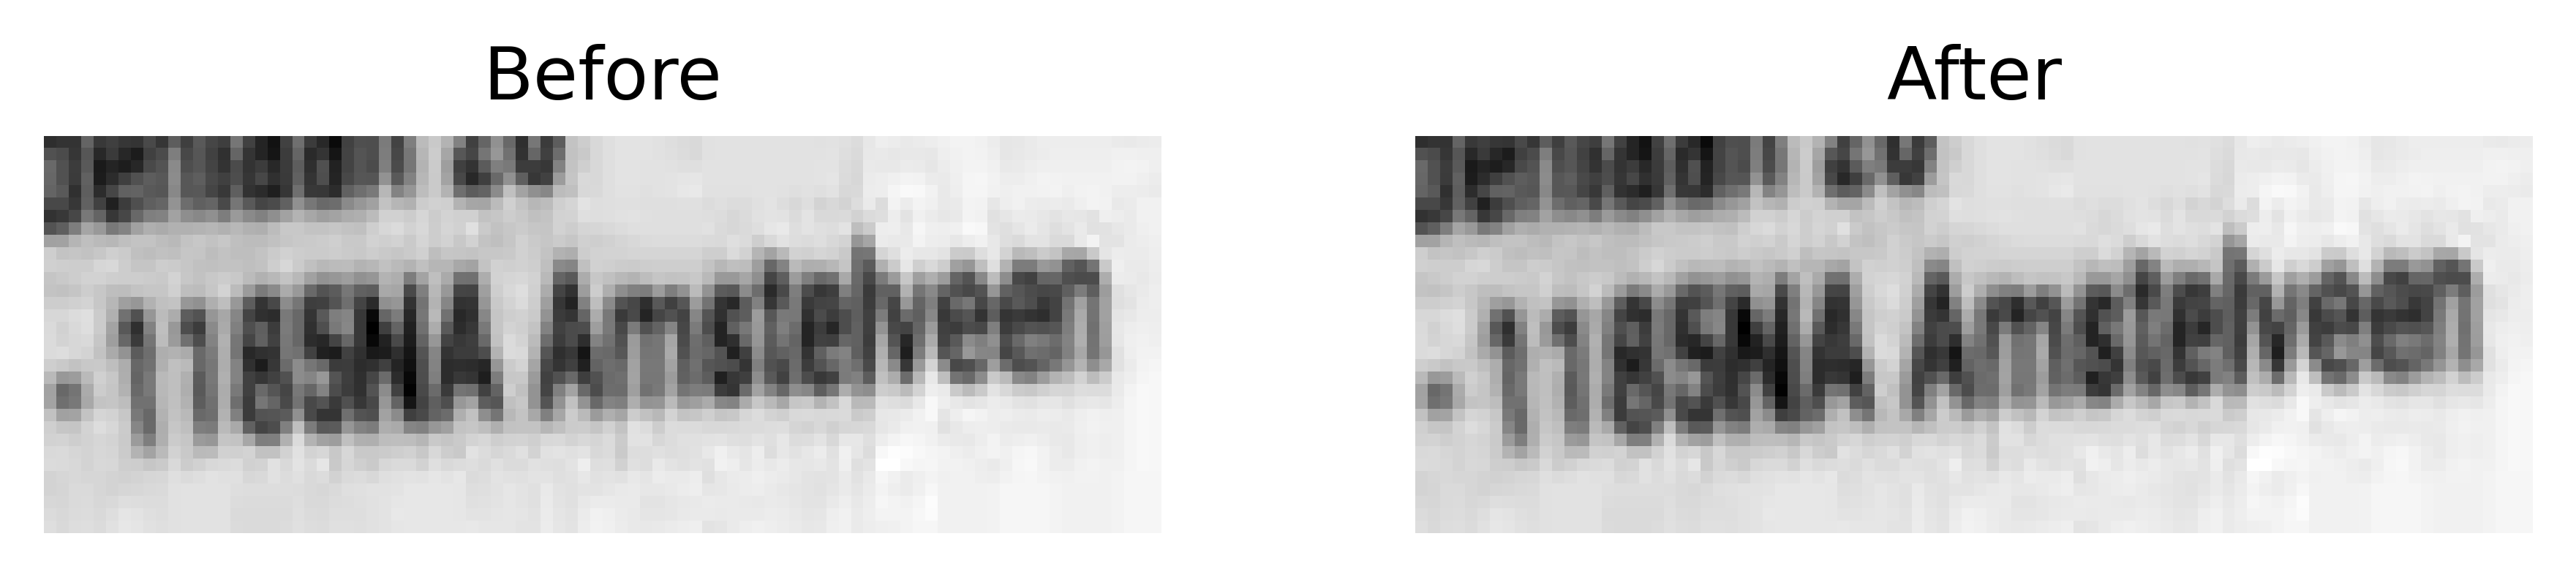

other 0.7450639009475708


RuntimeError: Input and output sizes should be greater than 0, but got input (H: 0, W: 54) output (H: 32, W: 90)

In [212]:
from torch.nn import functional as F

weight = torch.load('../blurred_img_clf/checkpoints/checkpoint_70.pkl', map_location=torch.device('cuda'))

bic_model = BICModel()
bic_model = nn.DataParallel(bic_model)
bic_model.load_state_dict(weight['model'])
bic_model = bic_model.requires_grad_(False).to('cuda')

dataset = ImageFolderDataset("../blurred_img_clf/dataset/")
for img in box:
    with torch.no_grad():
        lr = np.array(img)
        
        lr = lr.reshape(1, *lr.shape)
        lr = torch.from_numpy(lr).unsqueeze(0).float().cuda()/255
        
        lr = F.interpolate(lr, size=(32, 90), mode="bilinear")
        out = bic_model(lr)
        out = F.softmax(out.cpu(),1)[0]
        
        im_lr = lr.cpu().numpy().transpose([0, 2, 3, 1])
        plot_images(im_lr[0], im_lr[0])
        print(dataset.decoder_dict[int(np.argmax(out))], float(out[int(np.argmax(out))]))
    